<a target="_blank" href="https://colab.research.google.com/github/Jasonchen0317/CSGY-6613-Assignment/blob/main/TakeAtHome/take-at-home.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Problem Set 1 (Take Home) - 40 points

## PS 1.A - 20 points

In [this video](https://www.youtube.com/watch?v=ho6JXE3EbZ8) the author explains how to extract various visualizations of what CNNs learn. [Your course site](https://pantelis.github.io/artificial-intelligence/aiml-common/lectures/cnn/cnn-example-architectures/visualizing-what-convnets-learn.html) also covers the topic.

Using the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), train a ResNet-50 based CNN on the classification task of $K=9$ classes (filter out the class `ship`) and create the following visualizations for first, middle and last blocks of ResNet-50. You are free to select a class to showcase such visualizations.

* Visualizing intermediate convnet outputs (“intermediate activations”). This is useful to understand how successive convnet layers transform their input.

* Visualizing convnets filters. This is useful to understand precisely what visual pattern or concept each filter in a convnet is receptive to.

* Visualizing heatmaps of class activation in an image. This is useful to understand which part of an image where identified as belonging to a given class, and thus allows to localize objects in images.


# Train a ResNet-50 based CNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense
from keras import layers
from keras import optimizers
from keras import models

In [2]:
#load cifar10 data
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


In [3]:
#remove ship class(label==8) & change label 9 to 8
index = np.where(y_train.reshape(-1)==8)
x_train, y_train = np.delete(x_train, index, 0), np.delete(y_train, index, 0)
y_train[y_train==9]=8

index = np.where(y_test.reshape(-1)==8)
x_test, y_test = np.delete(x_test, index, 0), np.delete(y_test, index, 0)
y_test[y_test==9]=8

In [4]:
unique_values, counts = np.unique(y_train, return_counts=True)
for value, count in zip(unique_values, counts):
    print(f"{value} occurs {count} times")

0 occurs 5000 times
1 occurs 5000 times
2 occurs 5000 times
3 occurs 5000 times
4 occurs 5000 times
5 occurs 5000 times
6 occurs 5000 times
7 occurs 5000 times
8 occurs 5000 times


In [5]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=9)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=9)

In [79]:
#Build model
input_shape = (32, 32, 3)
n_class = 9
resnet_model = ResNet50(
    input_shape=input_shape,
    weights=None,
    include_top=False
)
flattened = tf.keras.layers.Flatten()(resnet_model.output)
fc1 = tf.keras.layers.Dense(128, activation='relu', name="AddedDense1")(flattened)
fc2 = tf.keras.layers.Dense(n_class, activation='softmax', name="AddedDense2")(fc1)

model = tf.keras.models.Model(inputs=resnet_model.input, outputs=fc2)

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])



Instructions for updating:
Colocations handled automatically by placer.


In [80]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [81]:
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test))

Train on 45000 samples, validate on 9000 samples
Epoch 1/20
 8448/45000 [====>.........................] - ETA: 2:52 - loss: 2.0318 - accuracy: 0.2666

KeyboardInterrupt: ignored

# Visualizing intermediate convnet outputs.

In [10]:
img_path = '0872.jpg'

# We preprocess the image into a 4D tensor
#from keras.preprocessing import image
import numpy as np

img = tf.keras.utils.load_img(img_path, target_size=(32, 32))
img_tensor = tf.keras.utils.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

(1, 32, 32, 3)


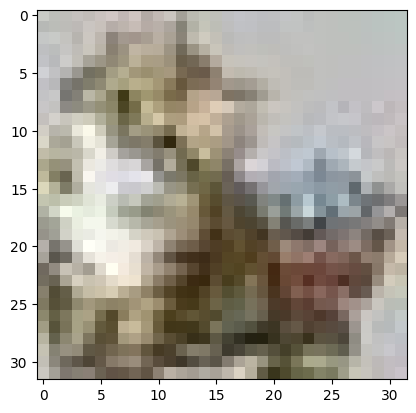

In [11]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [12]:
def get_layer_names(start, end):
  layer_names=[]
  for layer in model.layers[start:end]:
    layer_names.append(layer.name+'('+layer.__class__.__name__+')')
  return layer_names

In [25]:
#Function for plotting feature maps
def plot_feature_map(layer_names, activations):
  images_per_row = 16
  for layer_name, layer_activation in zip(layer_names, activations):
    if 'Conv2D' not in layer_name:
      continue

    n_features = layer_activation.shape[-1]
    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            # channel_image -= channel_image.mean()
            # channel_image /= channel_image.std()
            # channel_image *= 64
            # channel_image += 128
            # channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

  plt.show()

In [14]:
# Extracts the outputs of first block:
layer_outputs = [layer.output for layer in model.layers[:6]]
# Creates a model that will return these outputs, given the model input:
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

In [15]:
activations = activation_model.predict(img_tensor)

1/1 [==============================] - 0s 108ms/step


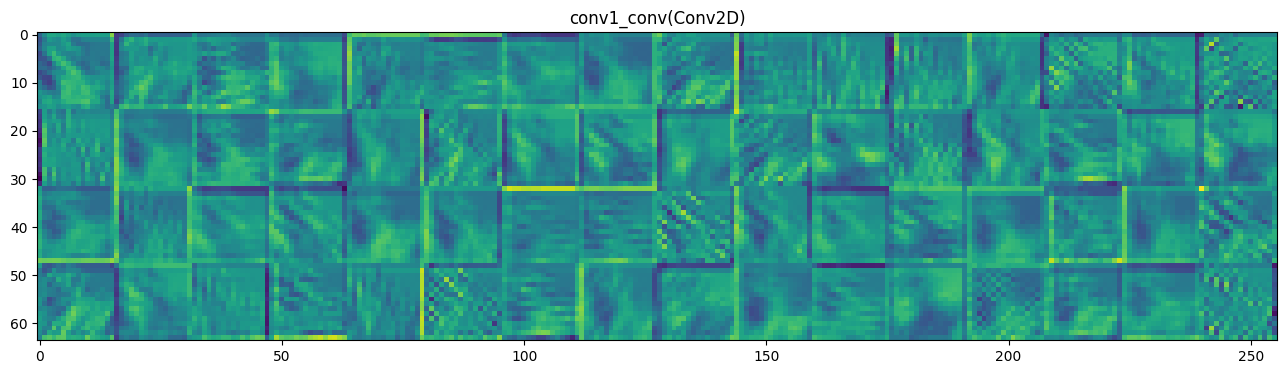

In [26]:
#Plot feature map for the first block
layer_names = get_layer_names(0, 6)

# Now let's display our feature maps
plot_feature_map(layer_names, activations)

In [27]:
# Extracts the outputs of Block 3
layer_outputs = [layer.output for layer in model.layers[38:78]]

# Creates a model that will return these outputs, given the model input:
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)

1/1 [==============================] - 1s 762ms/step


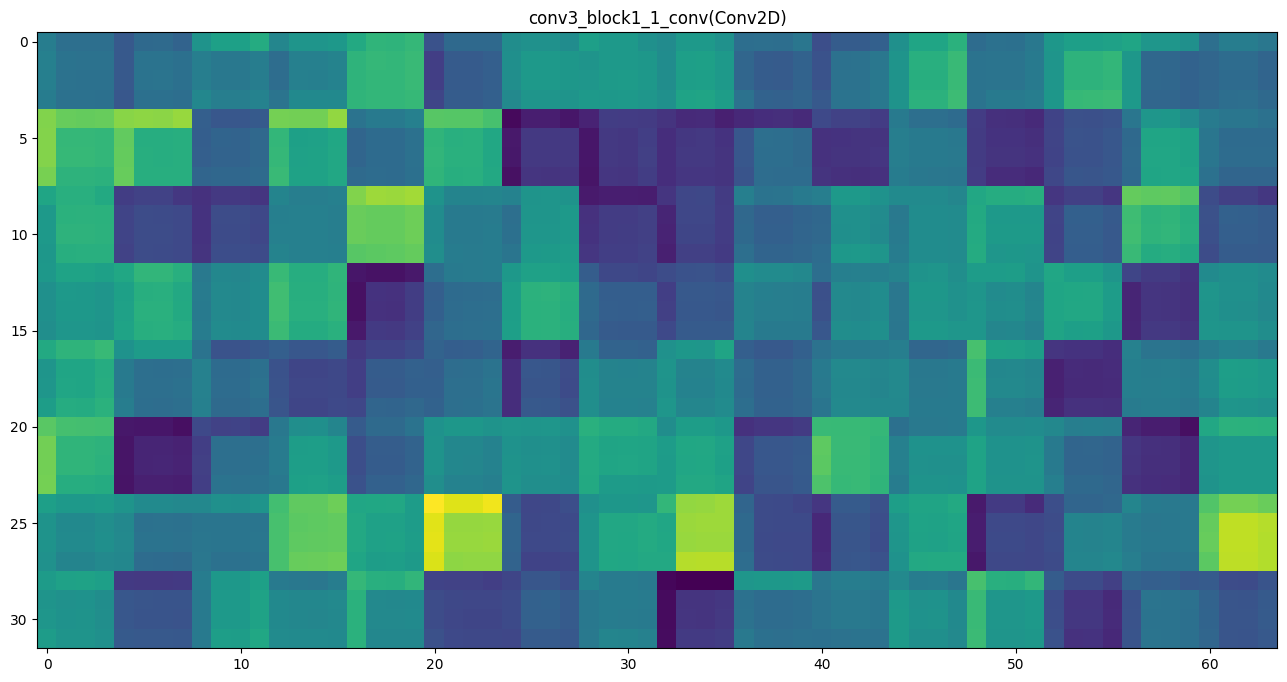

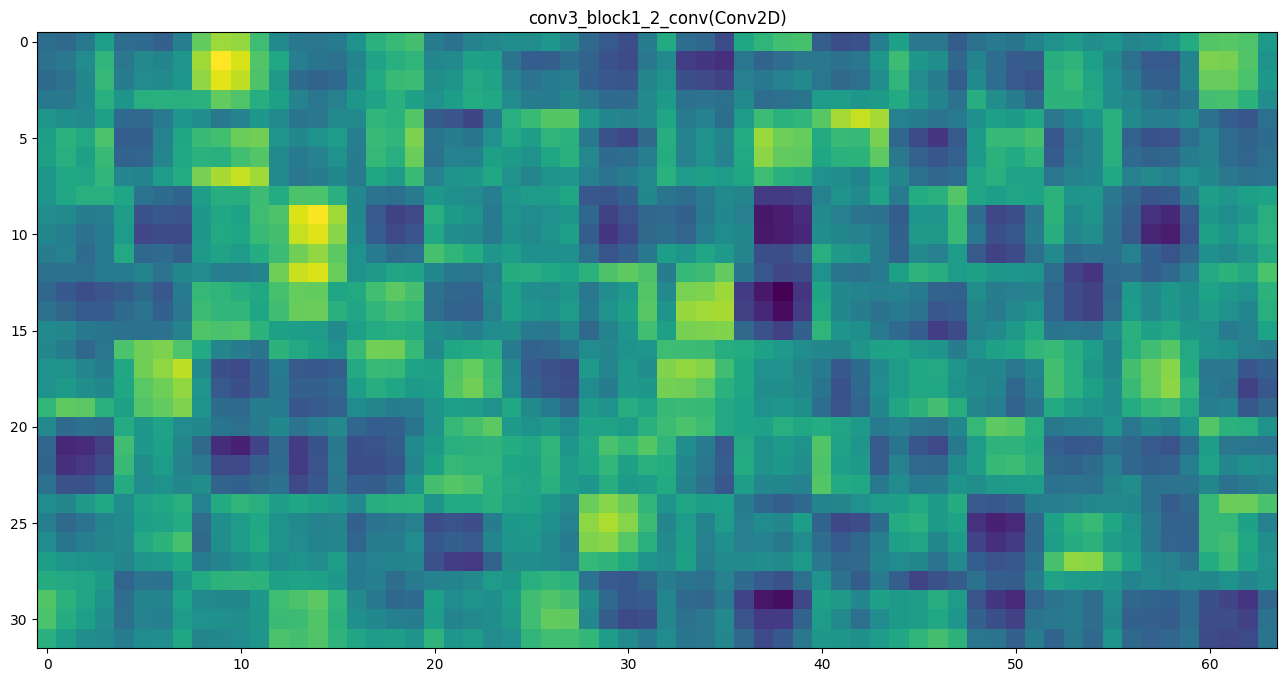

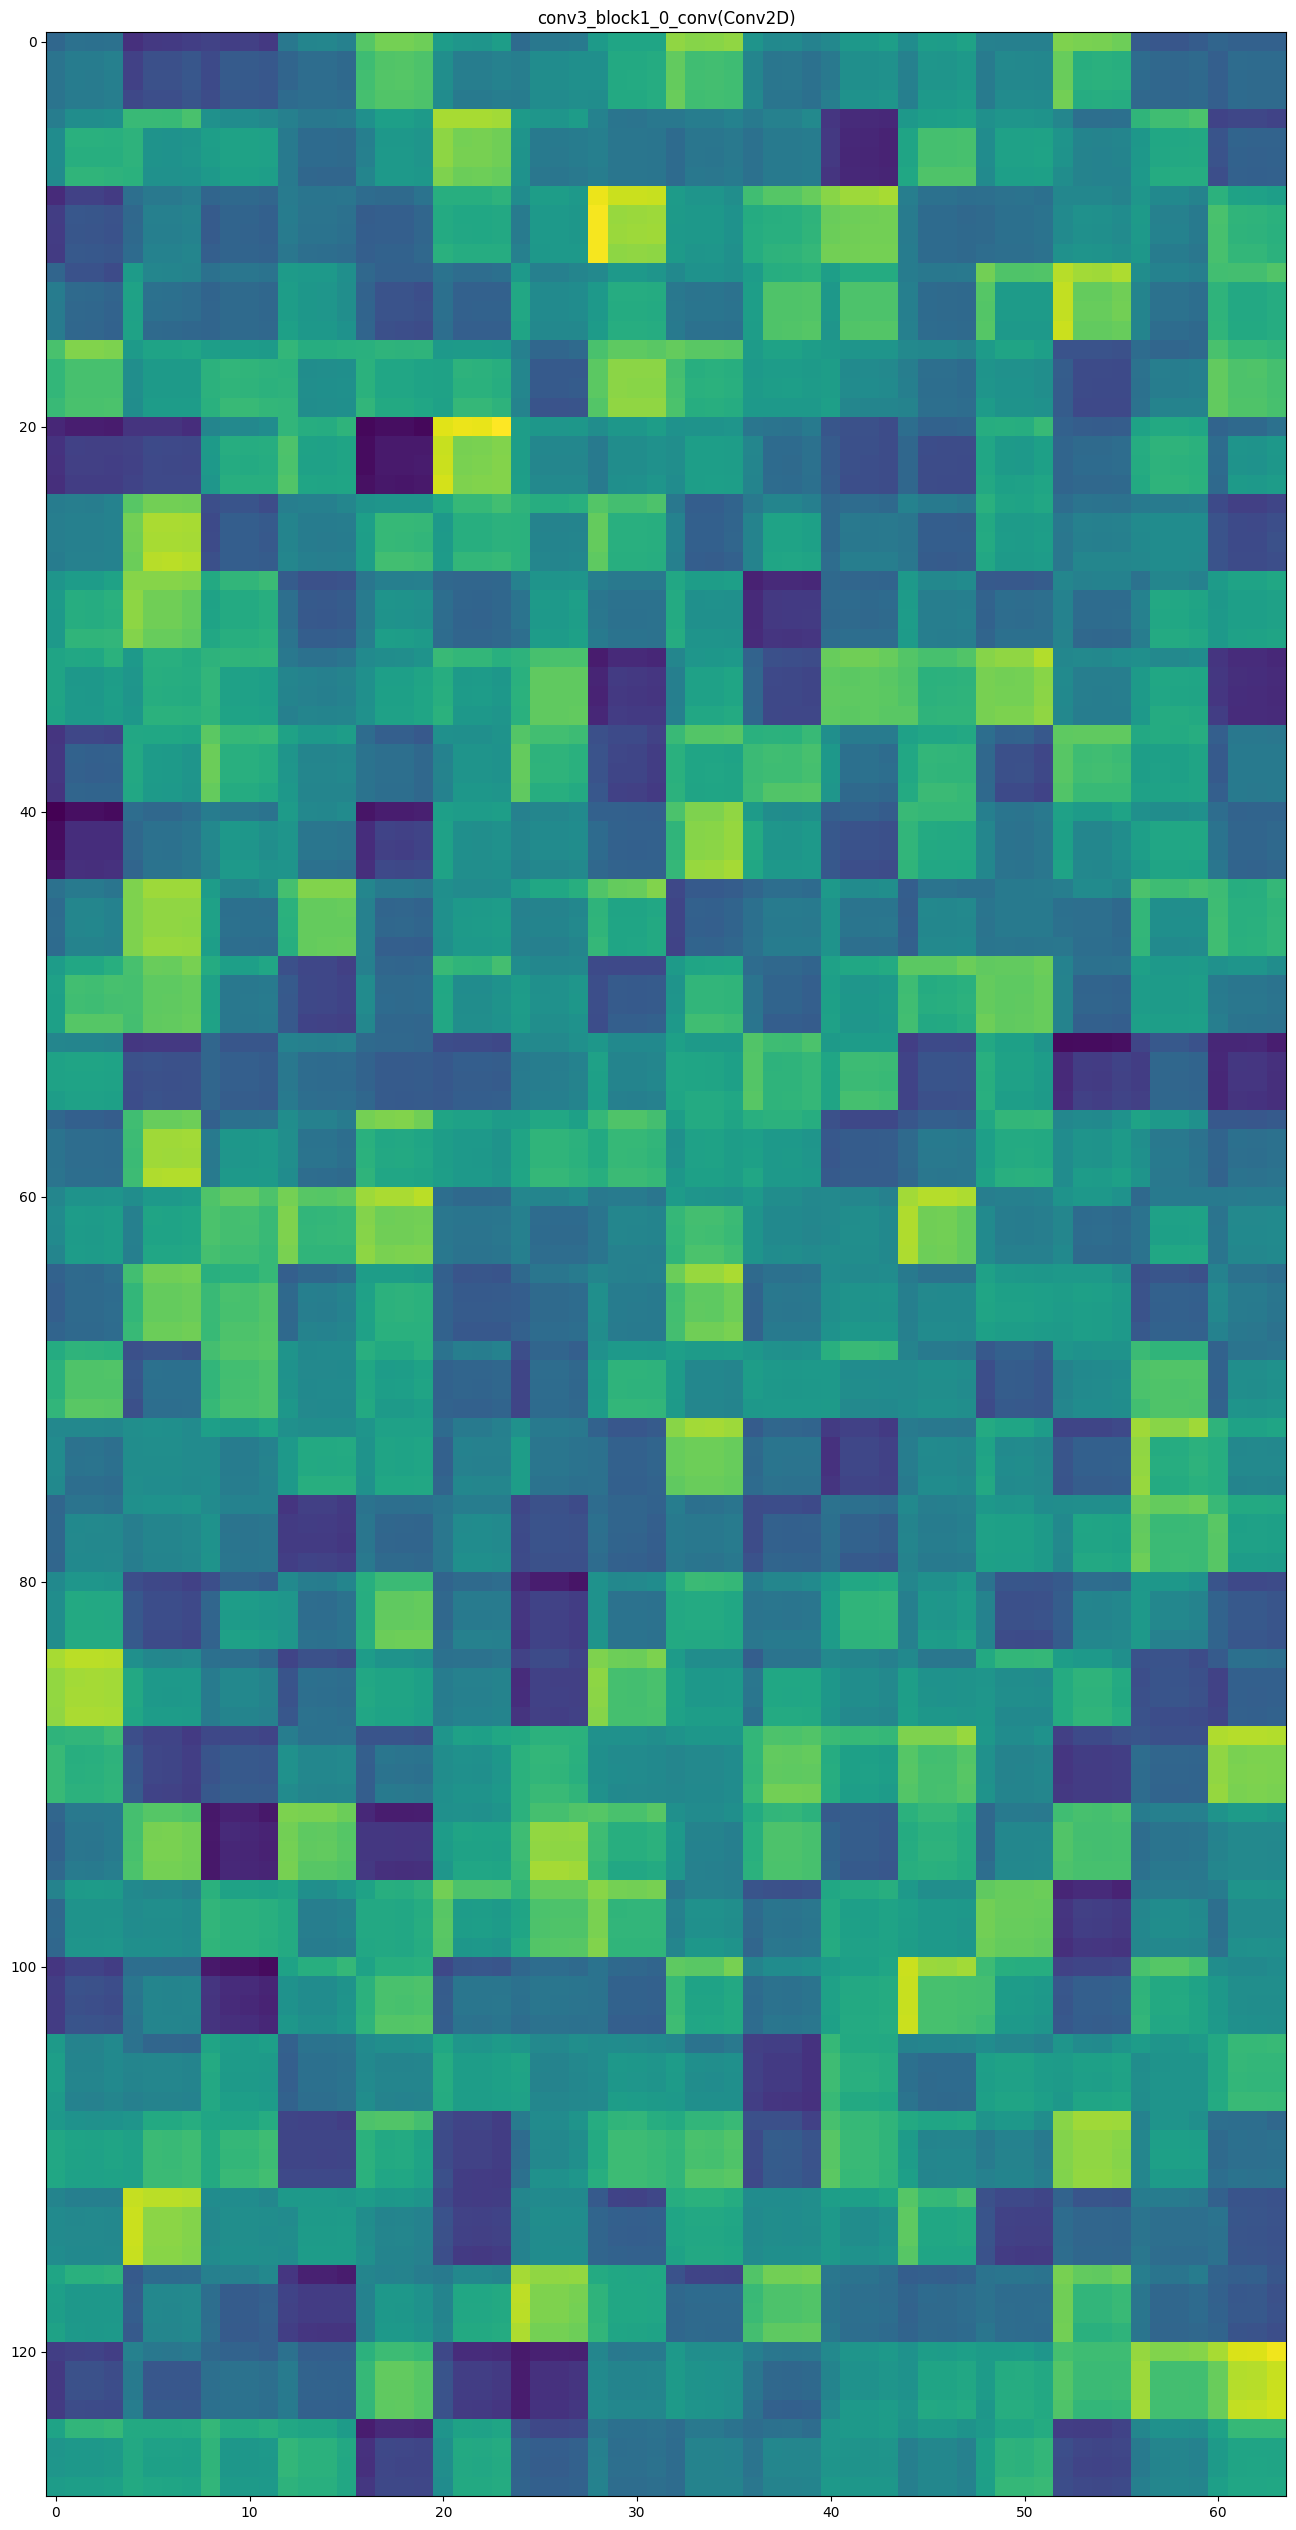

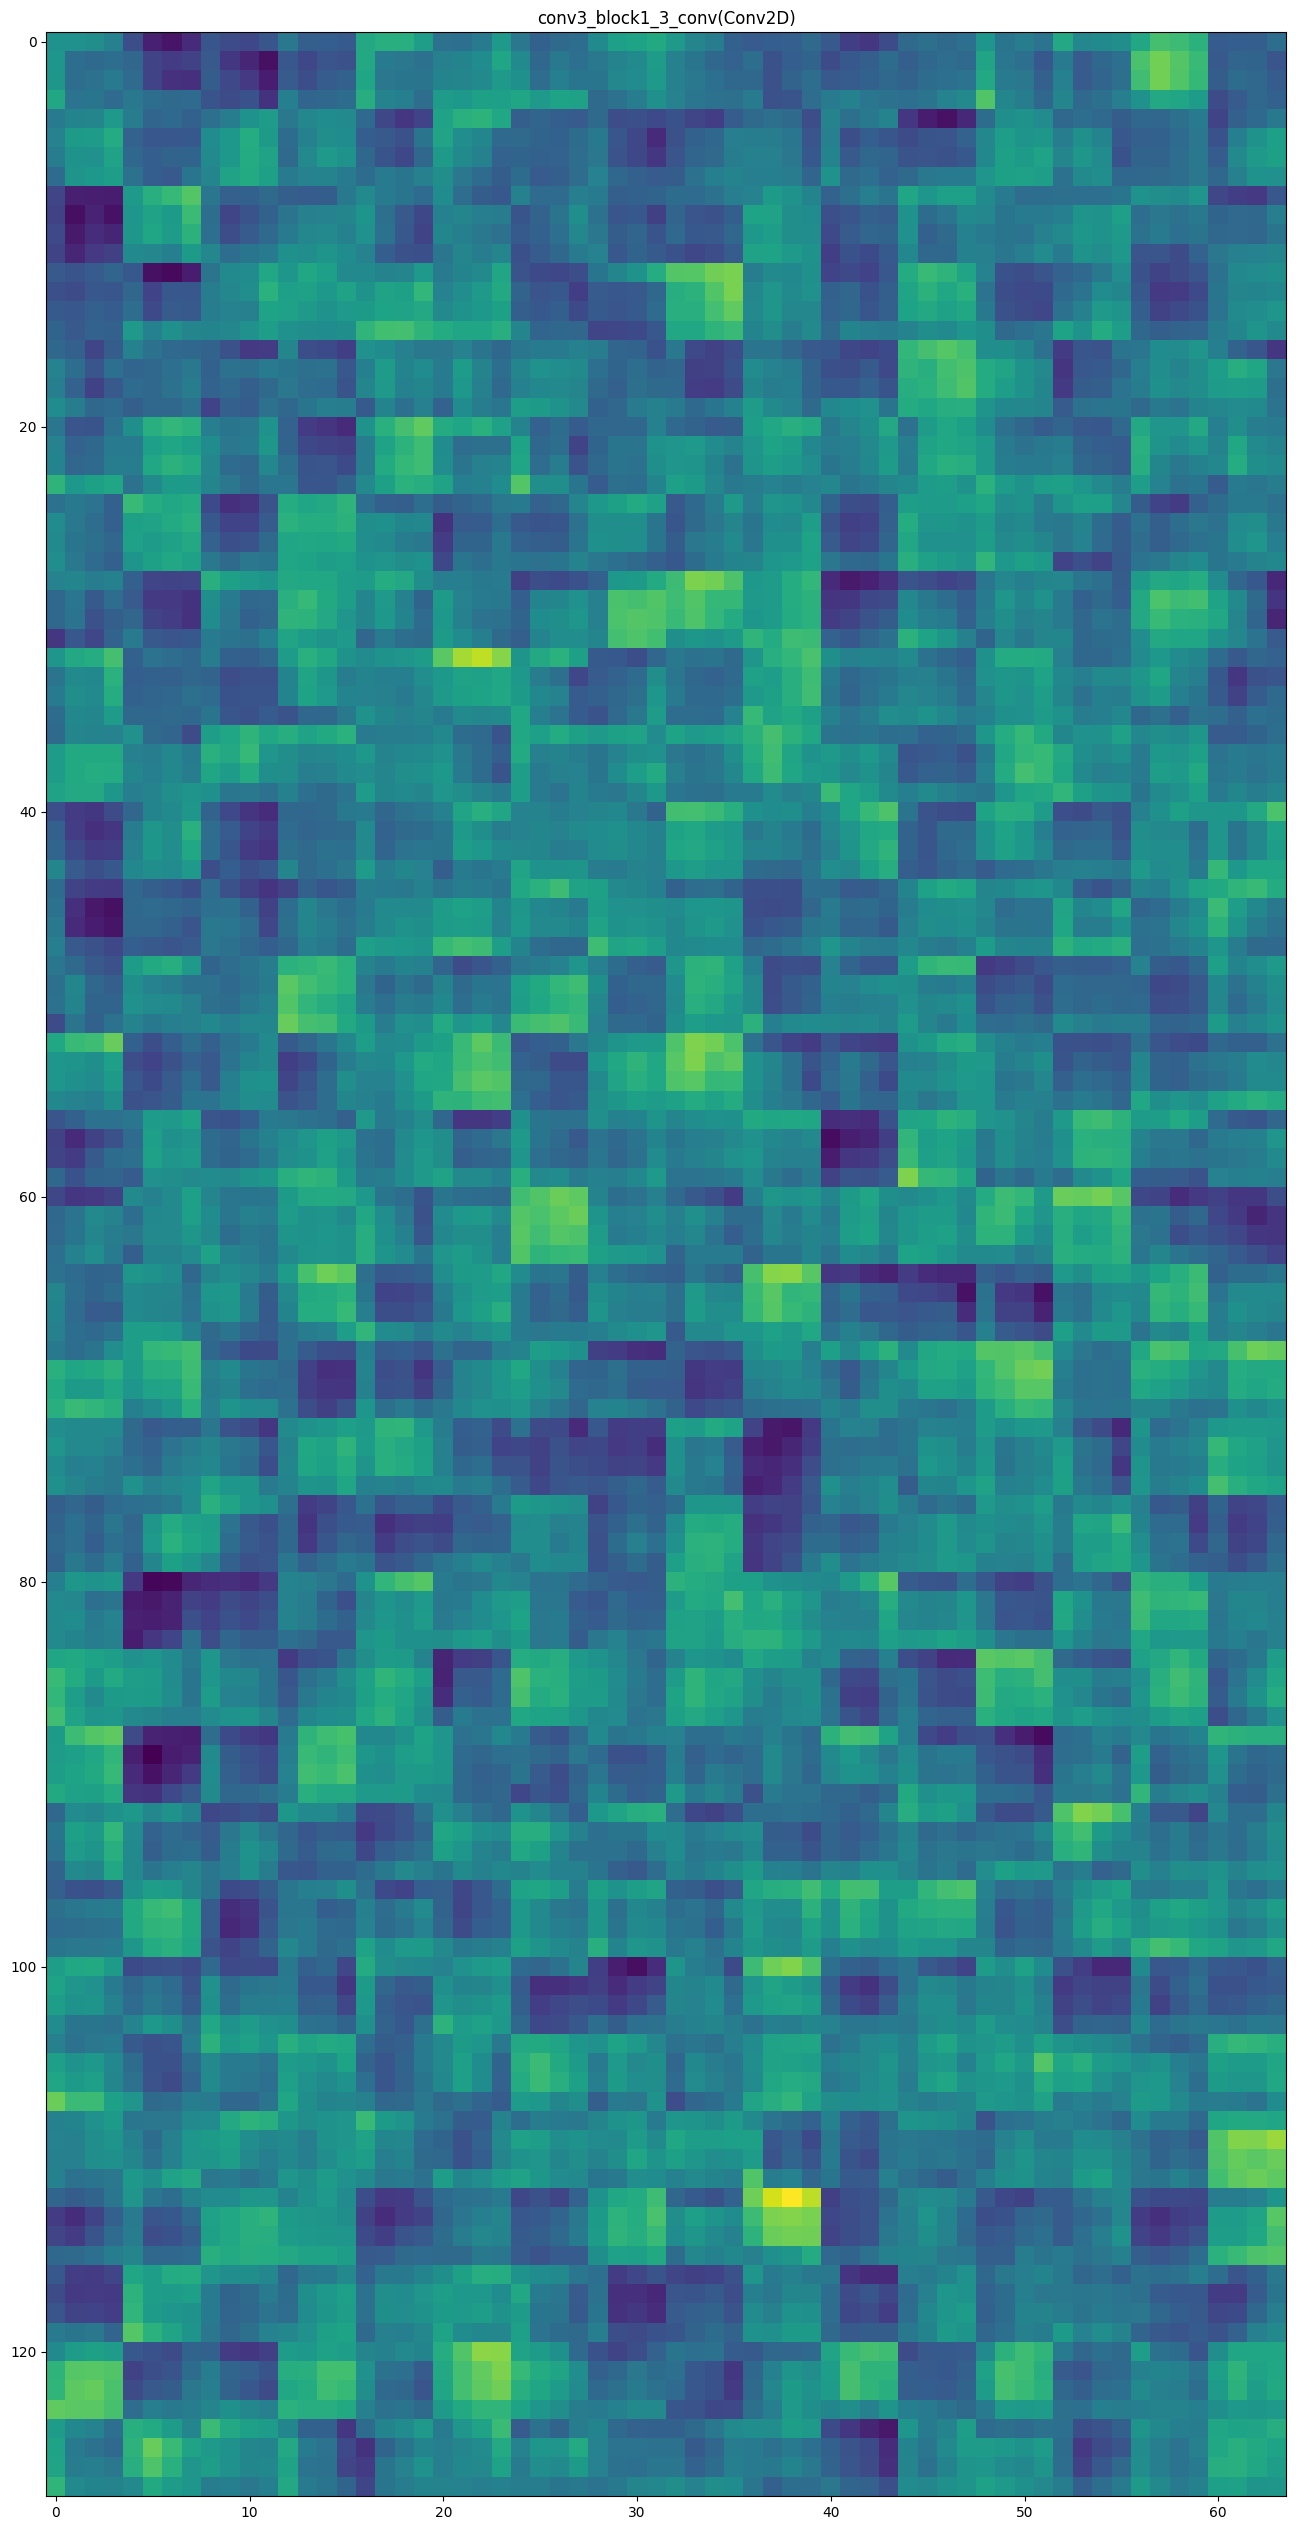

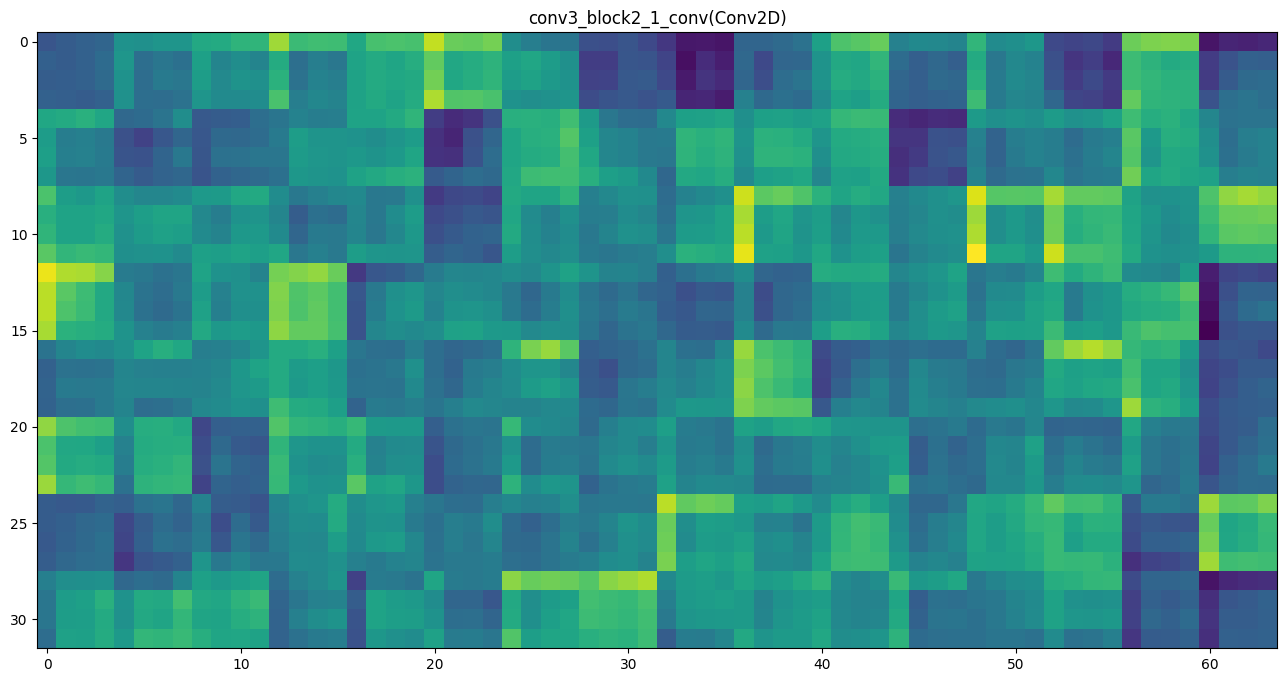

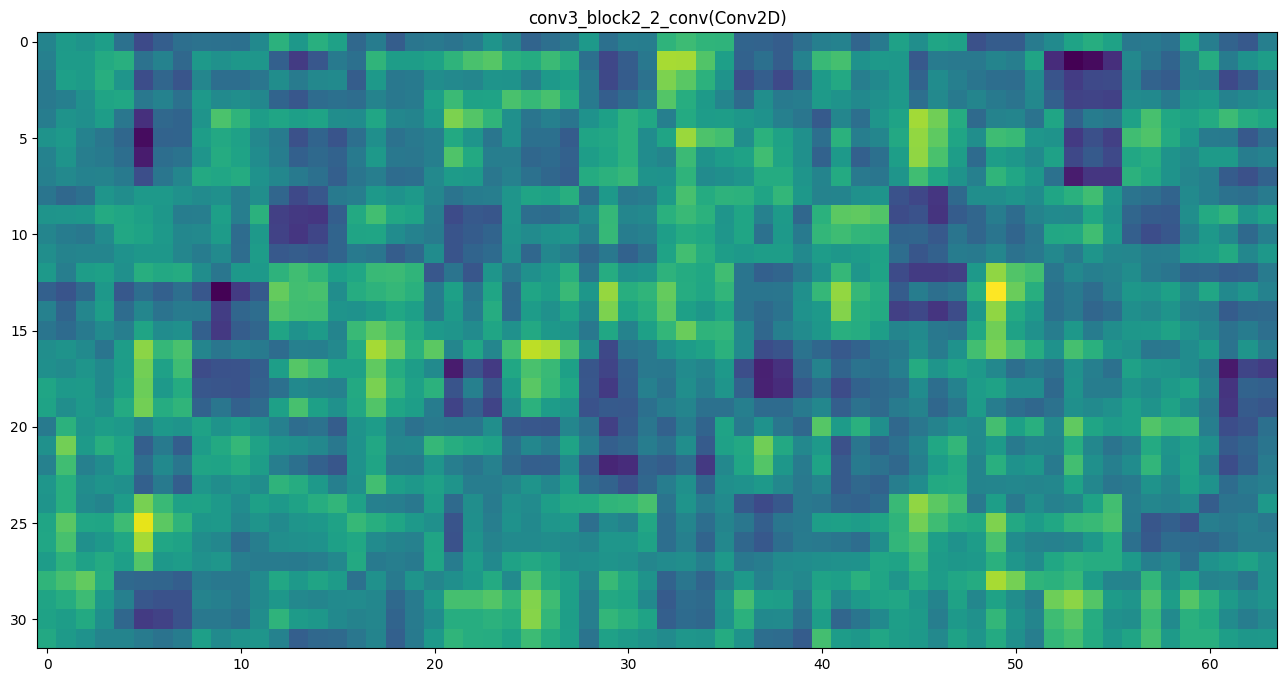

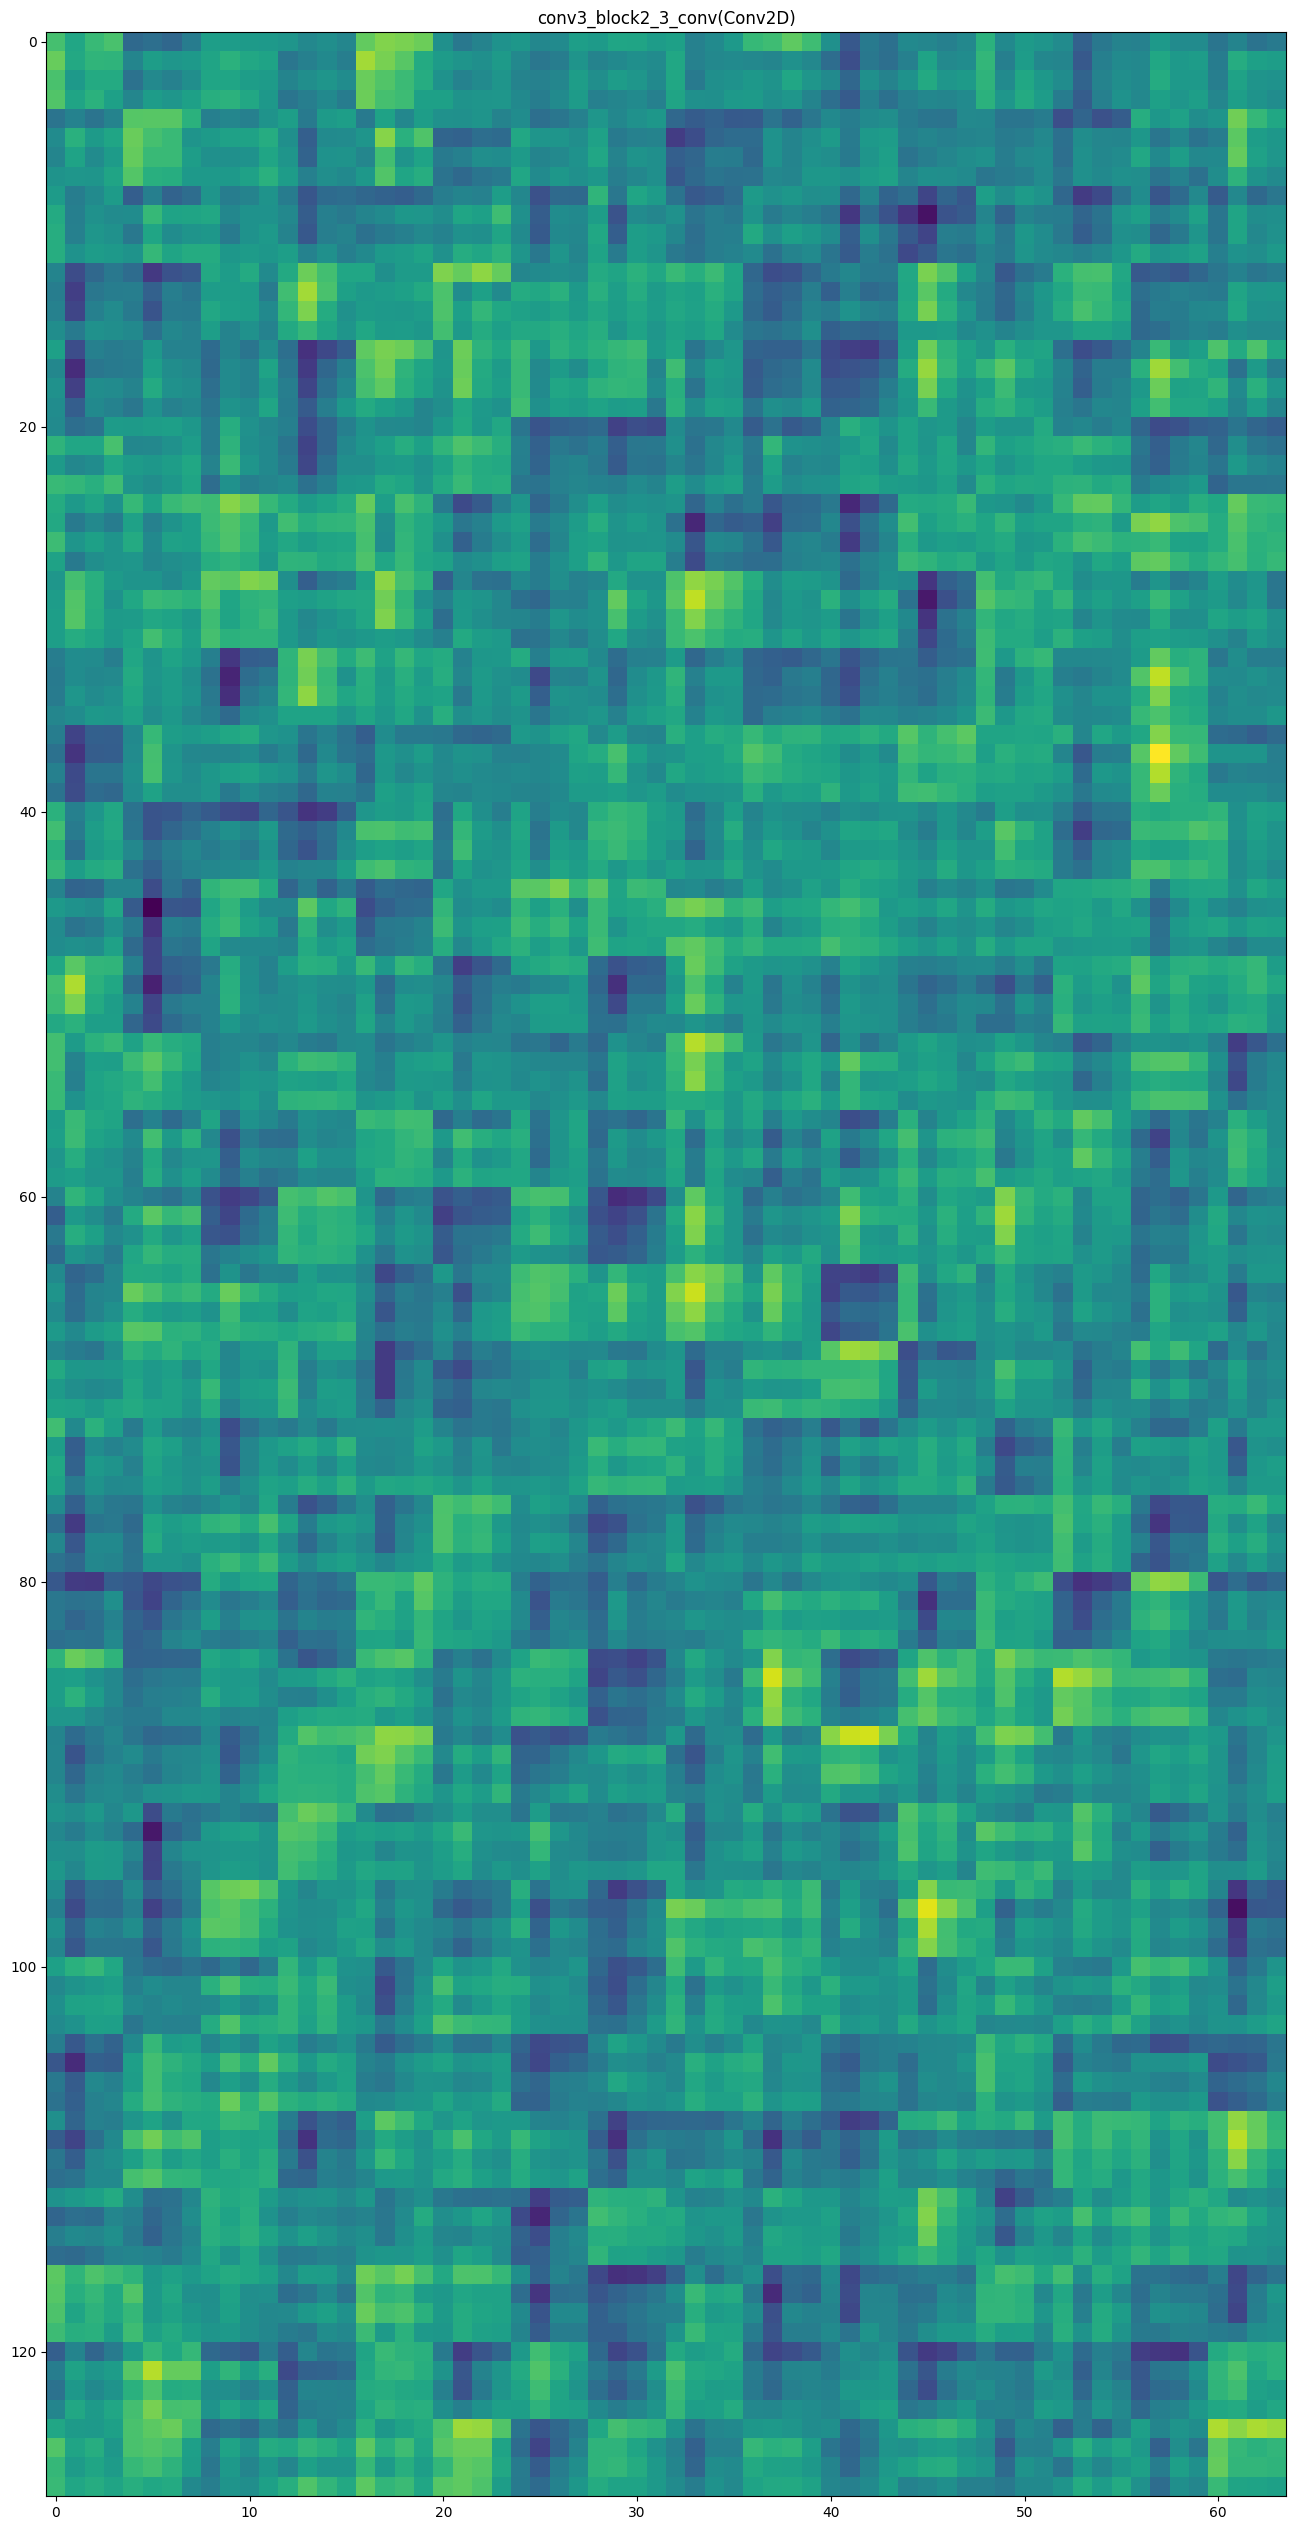

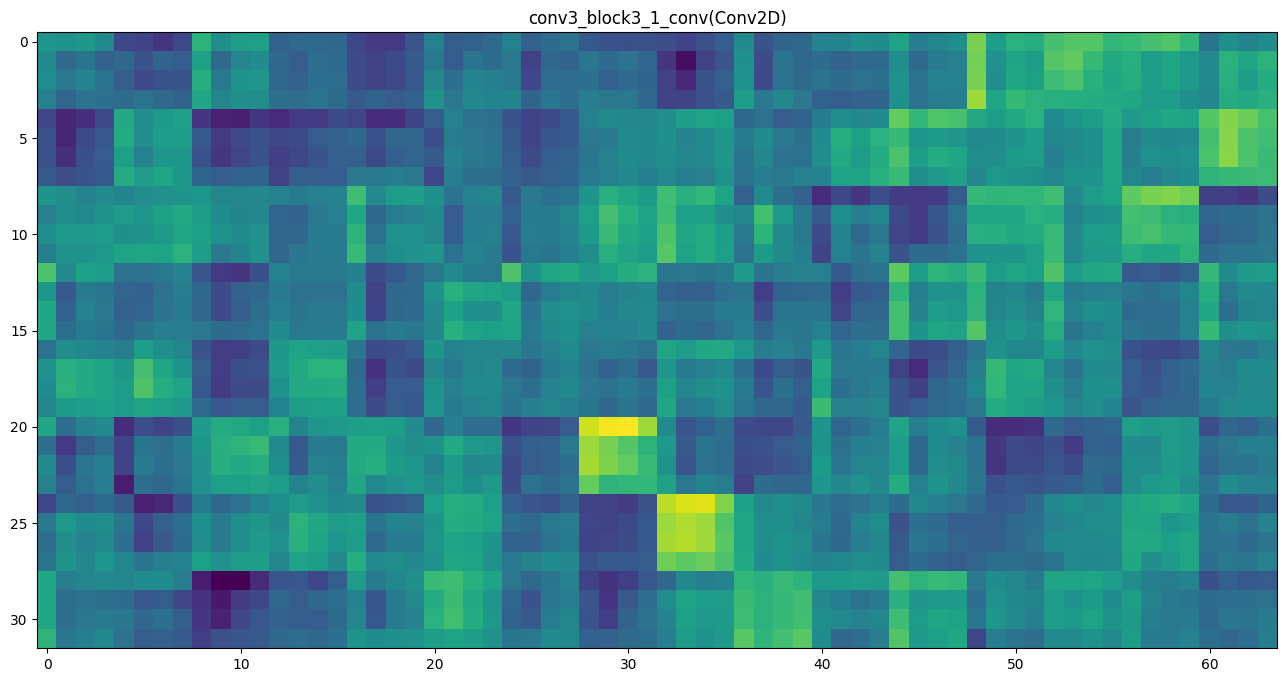

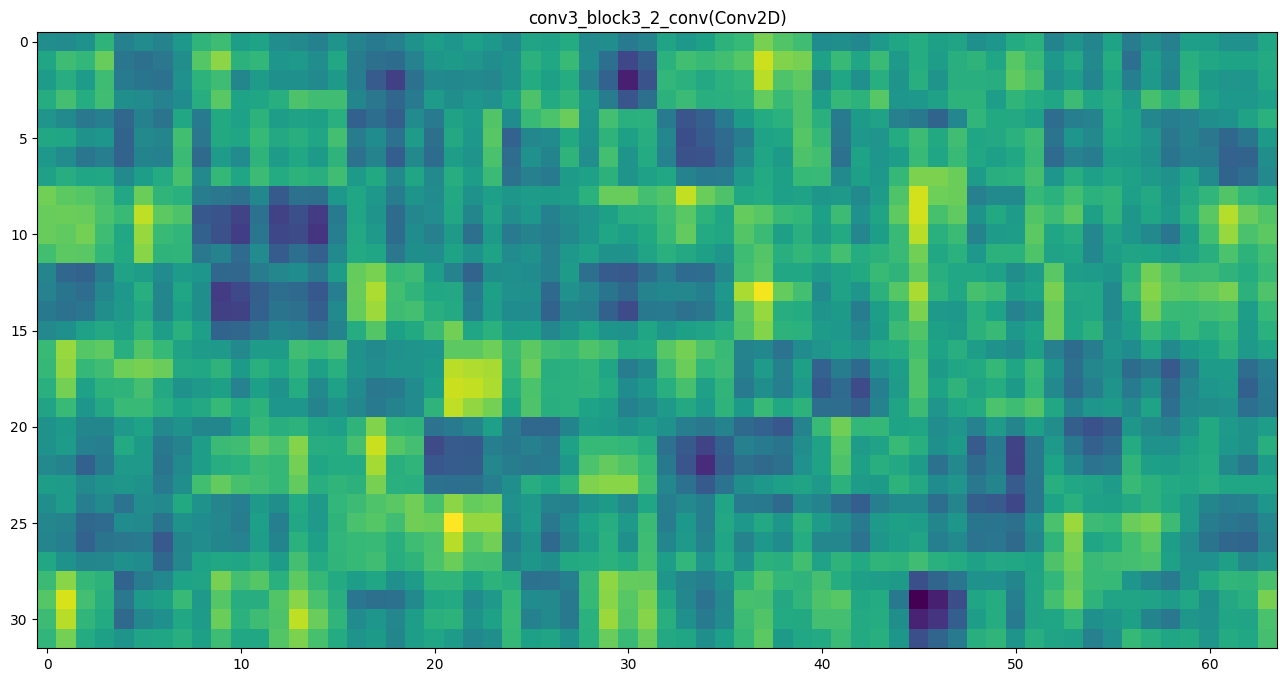

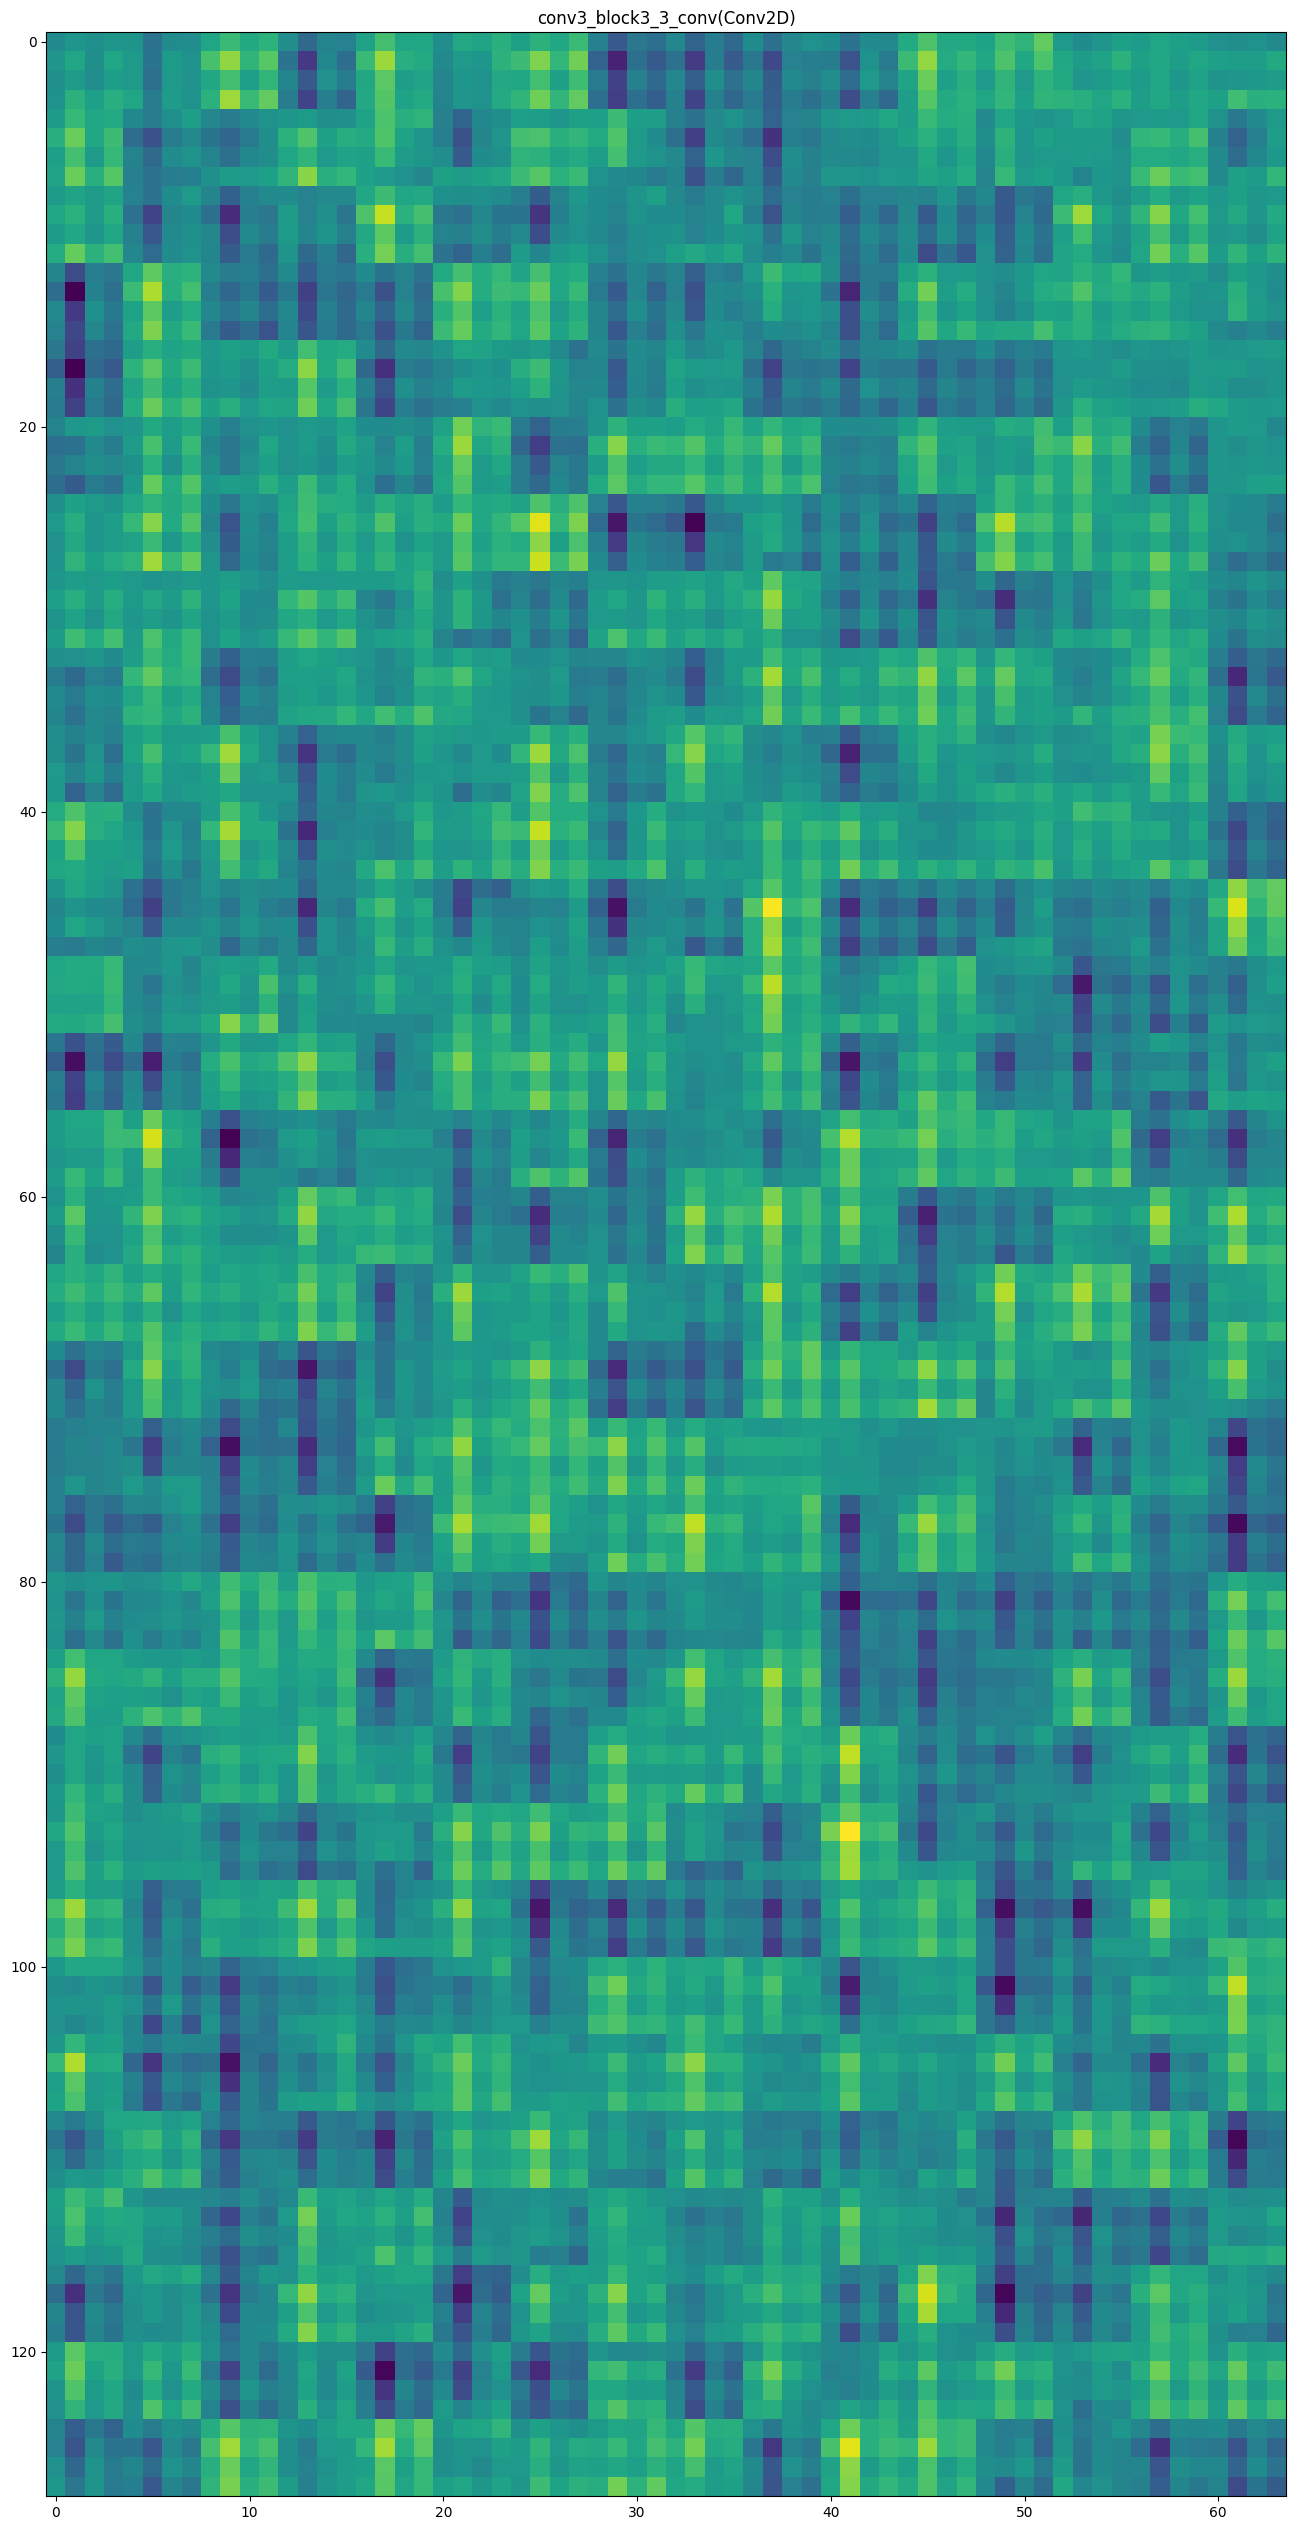

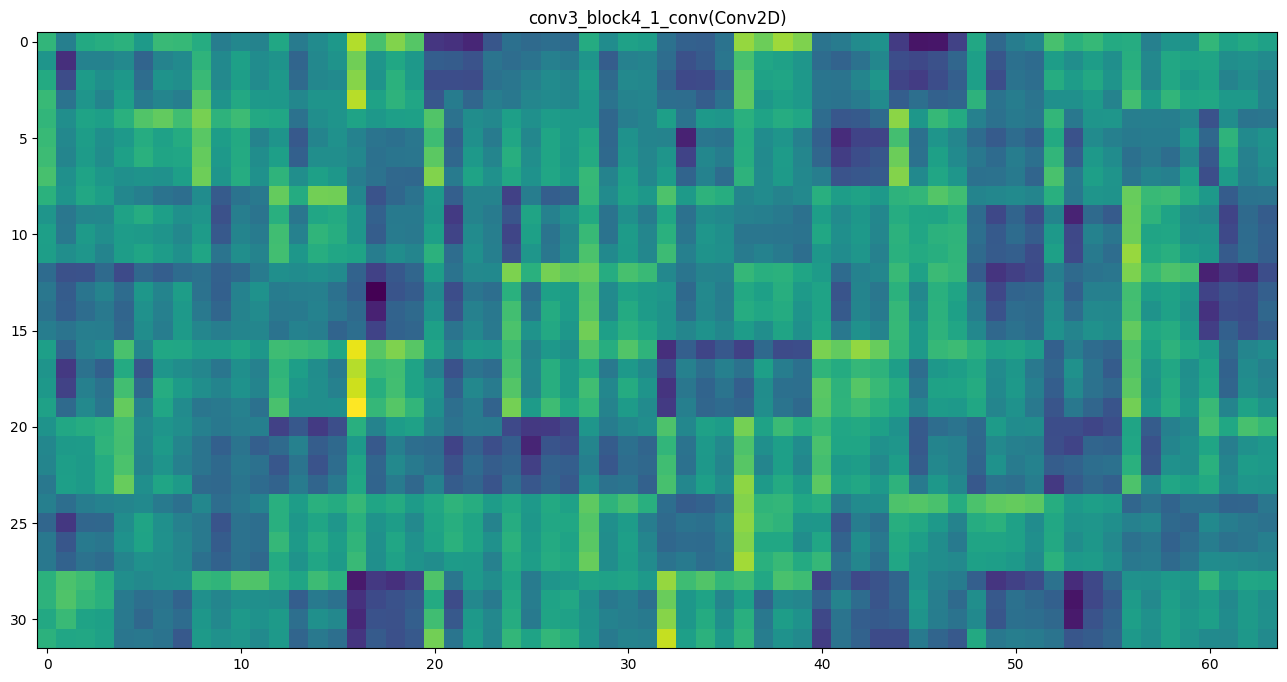

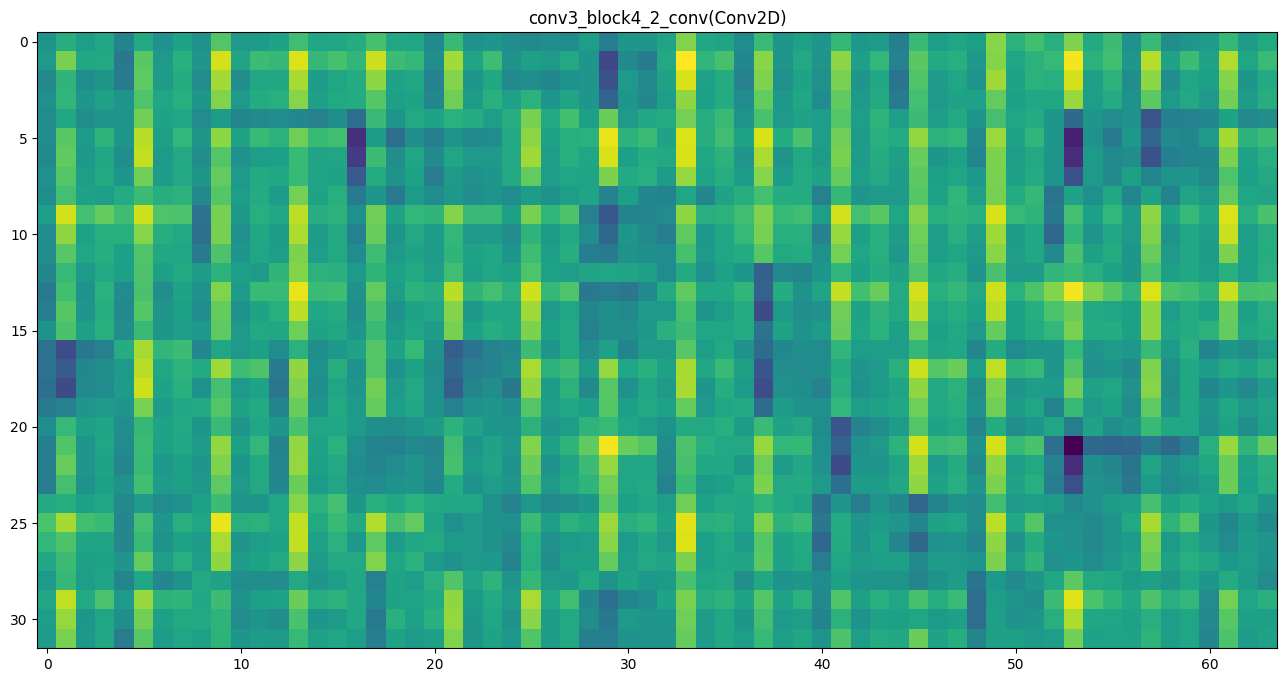

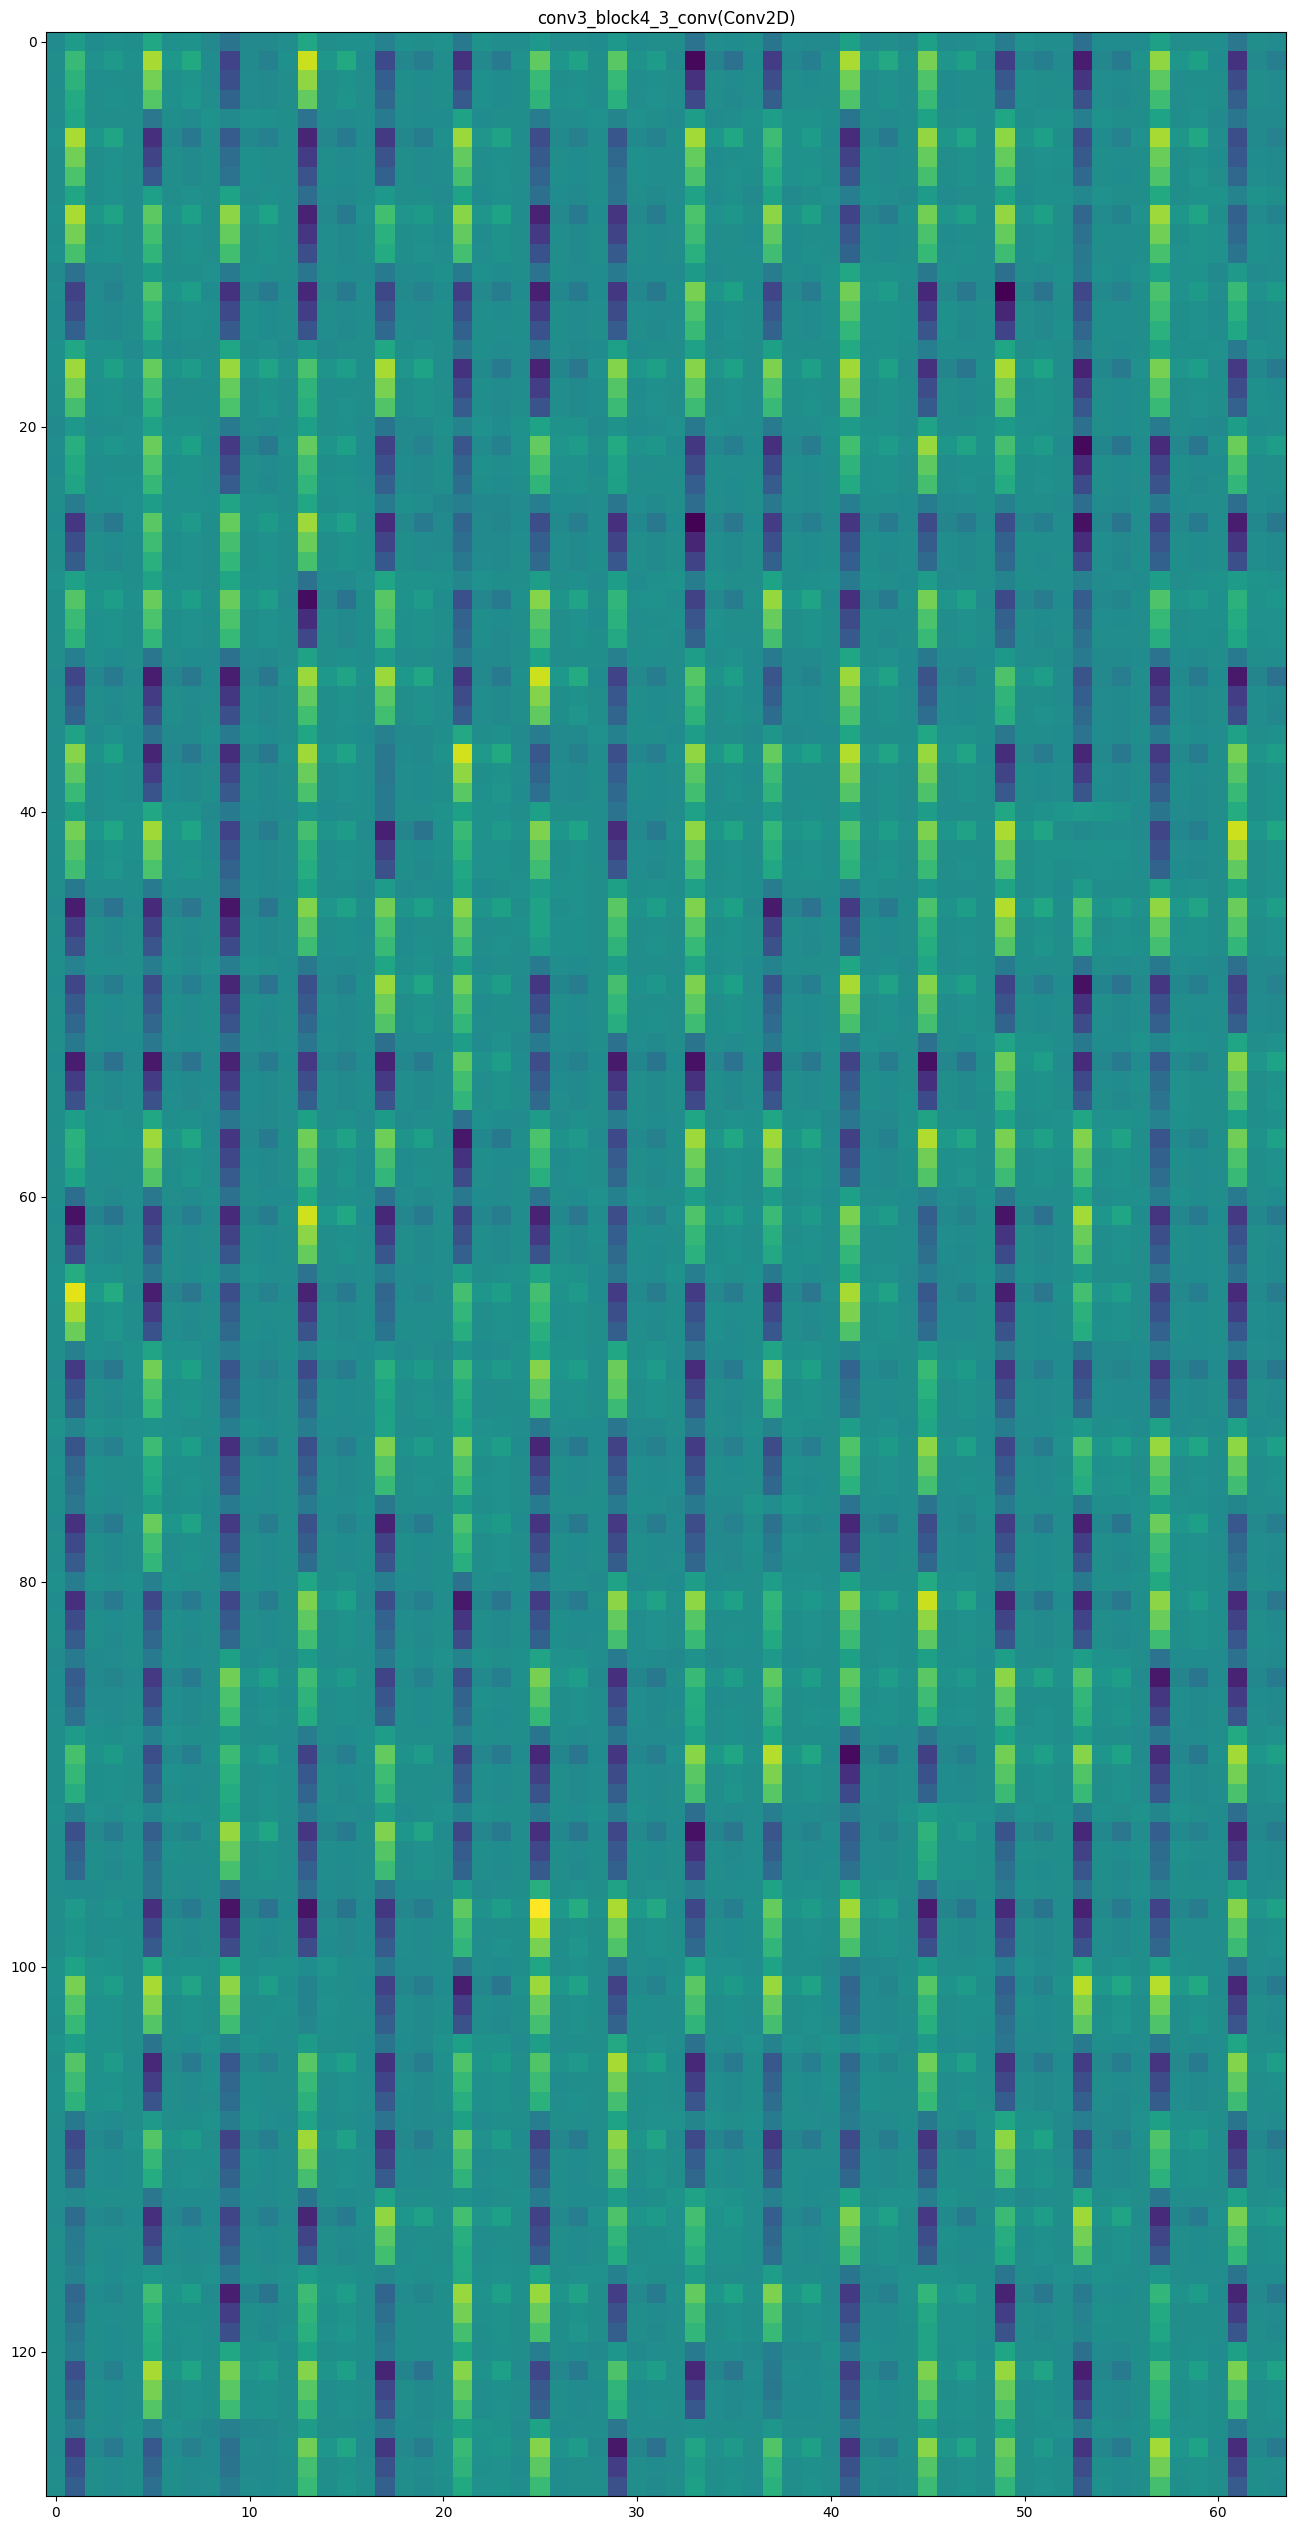

In [28]:
#get the names of the layers
layer_names = get_layer_names(38, 78)

#plot feature maps
plot_feature_map(layer_names, activations)

In [29]:
# Extracts the outputs of Block 5
layer_outputs = [layer.output for layer in model.layers[141:172]]
# Creates a model that will return these outputs, given the model input:
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)

1/1 [==============================] - 1s 1s/step


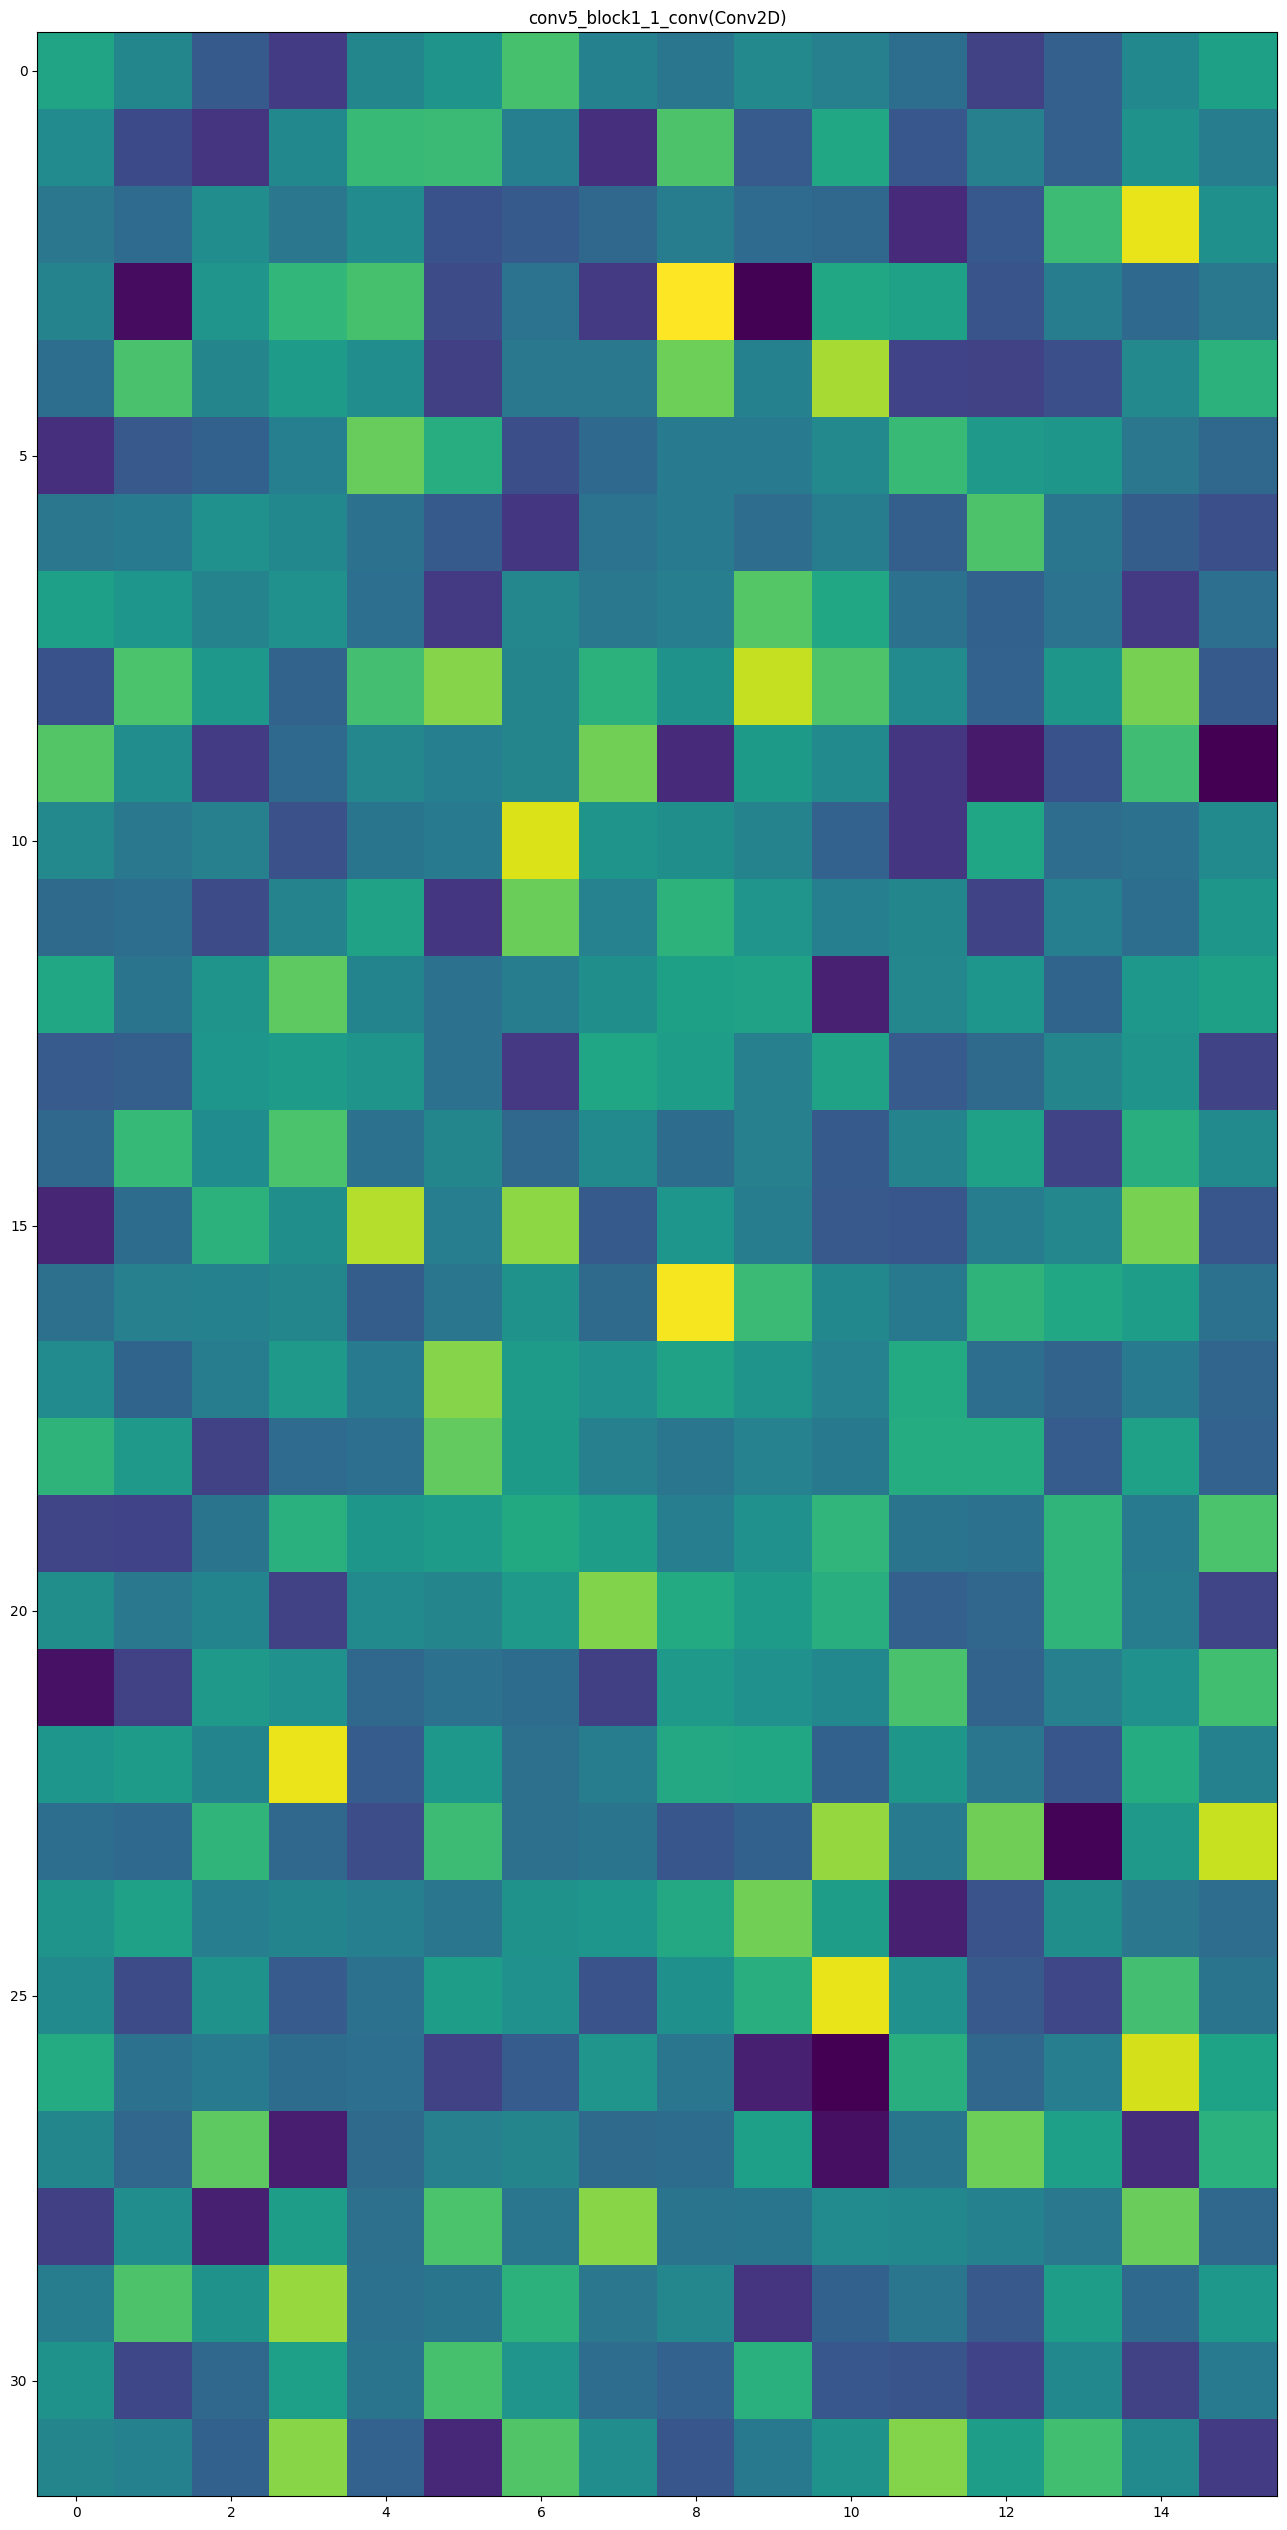

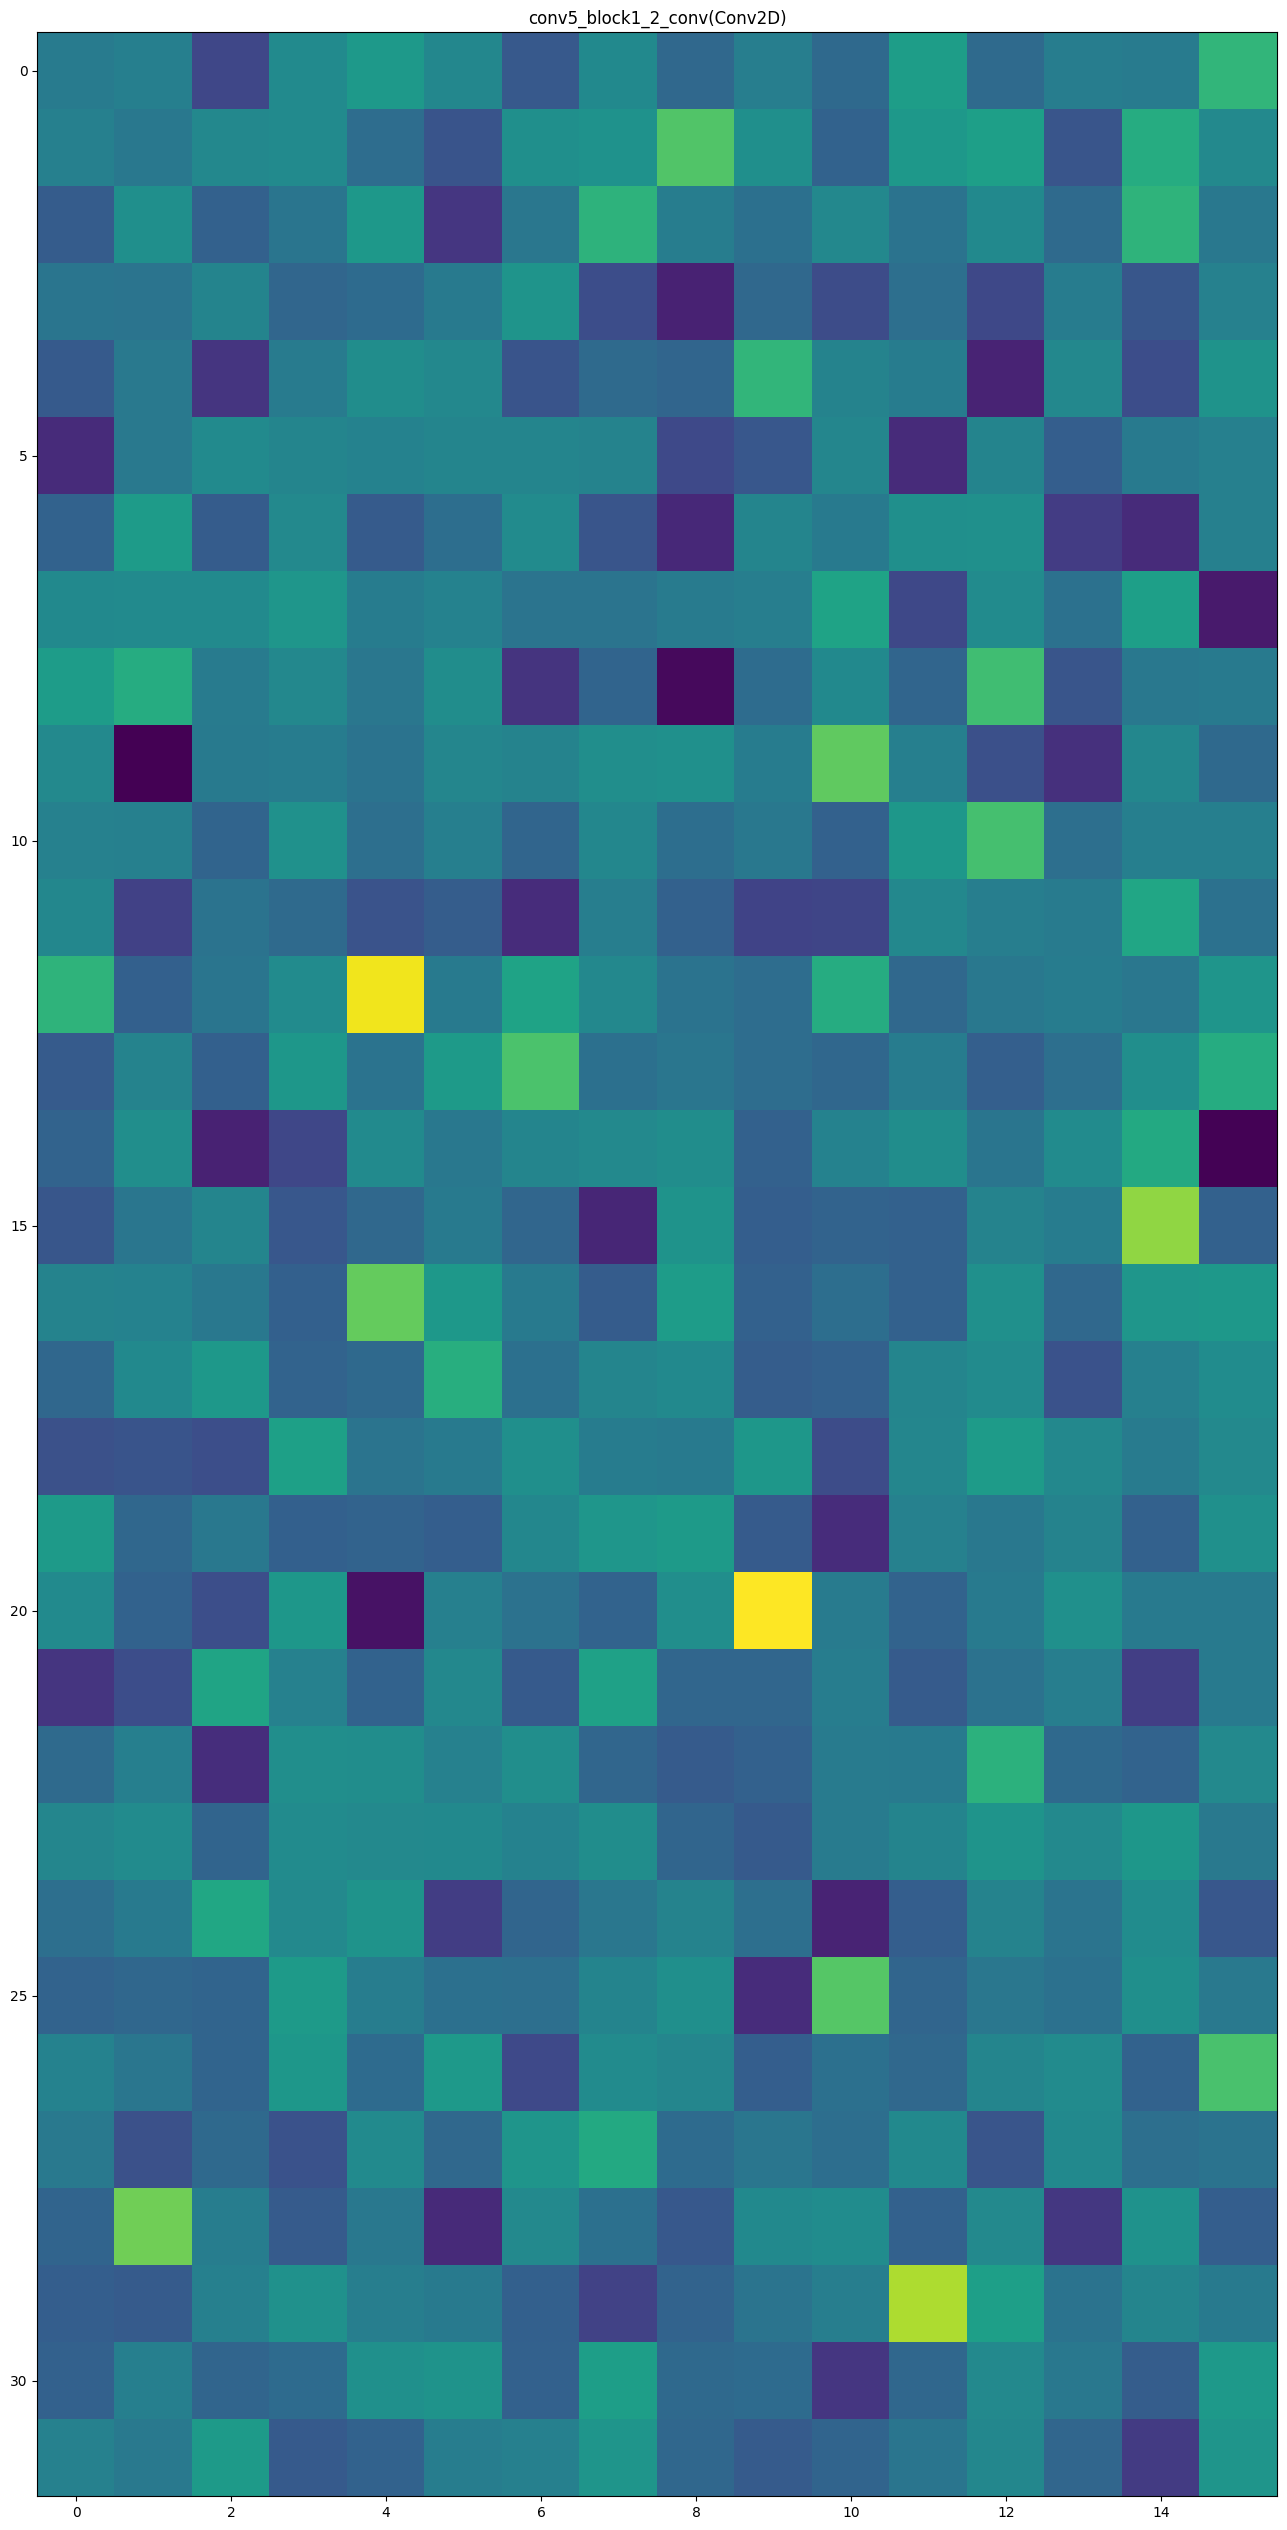

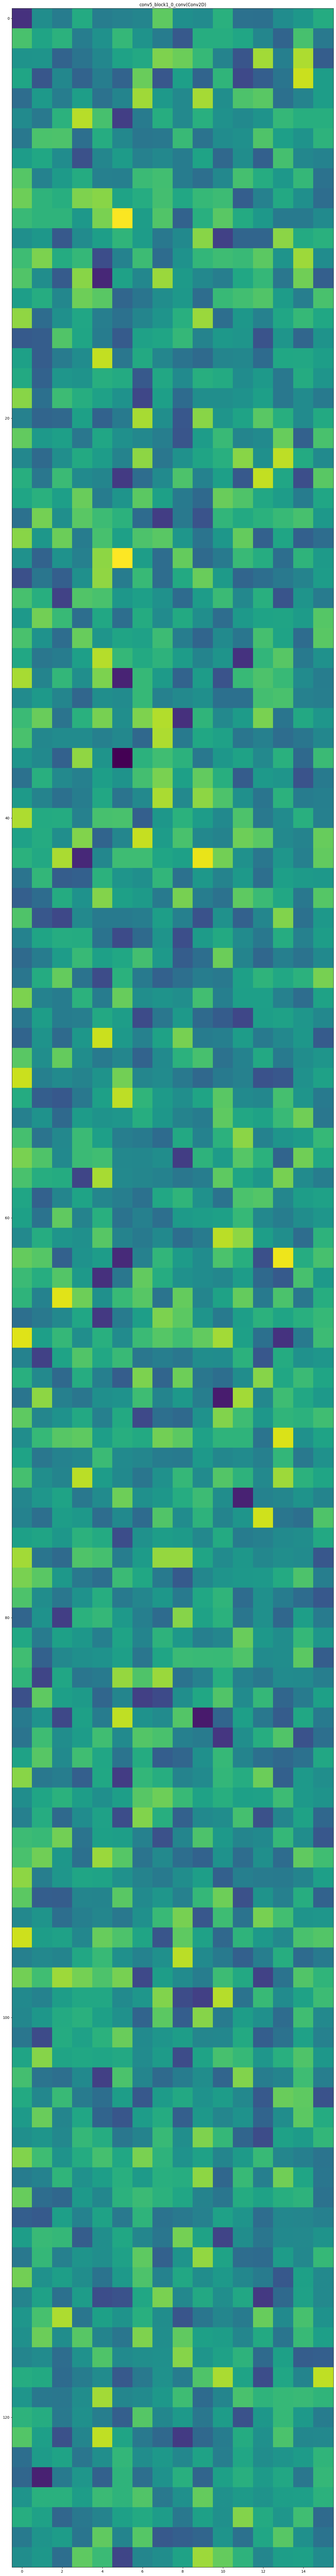

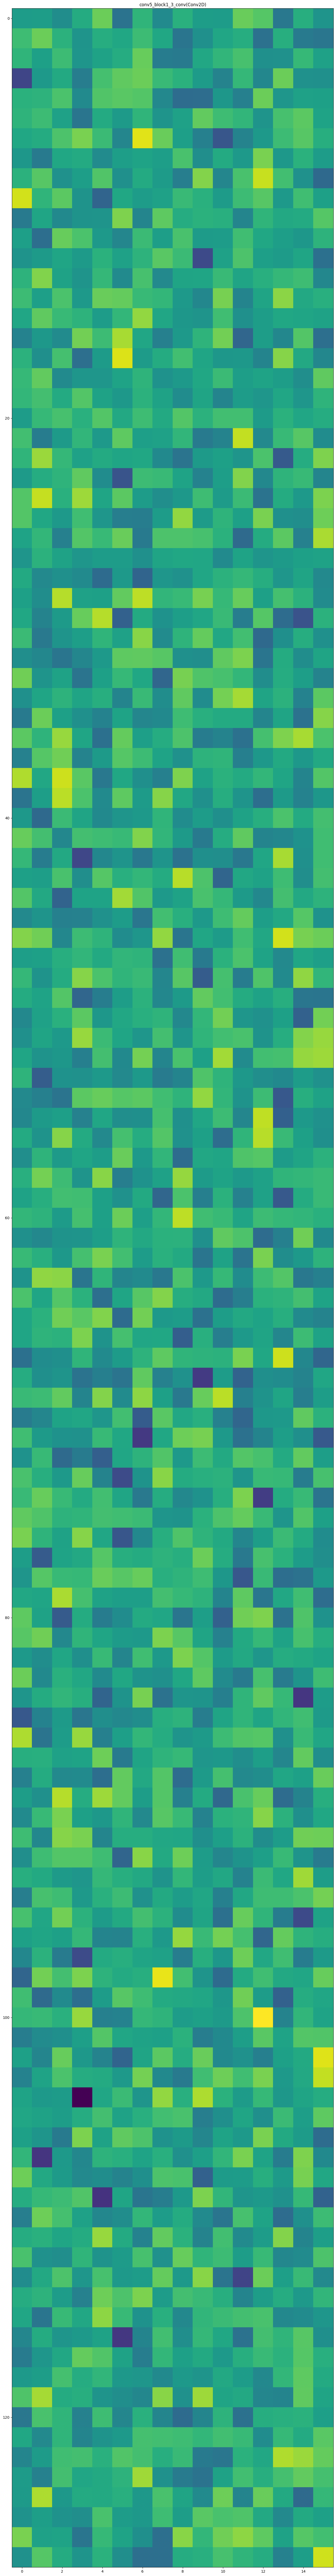

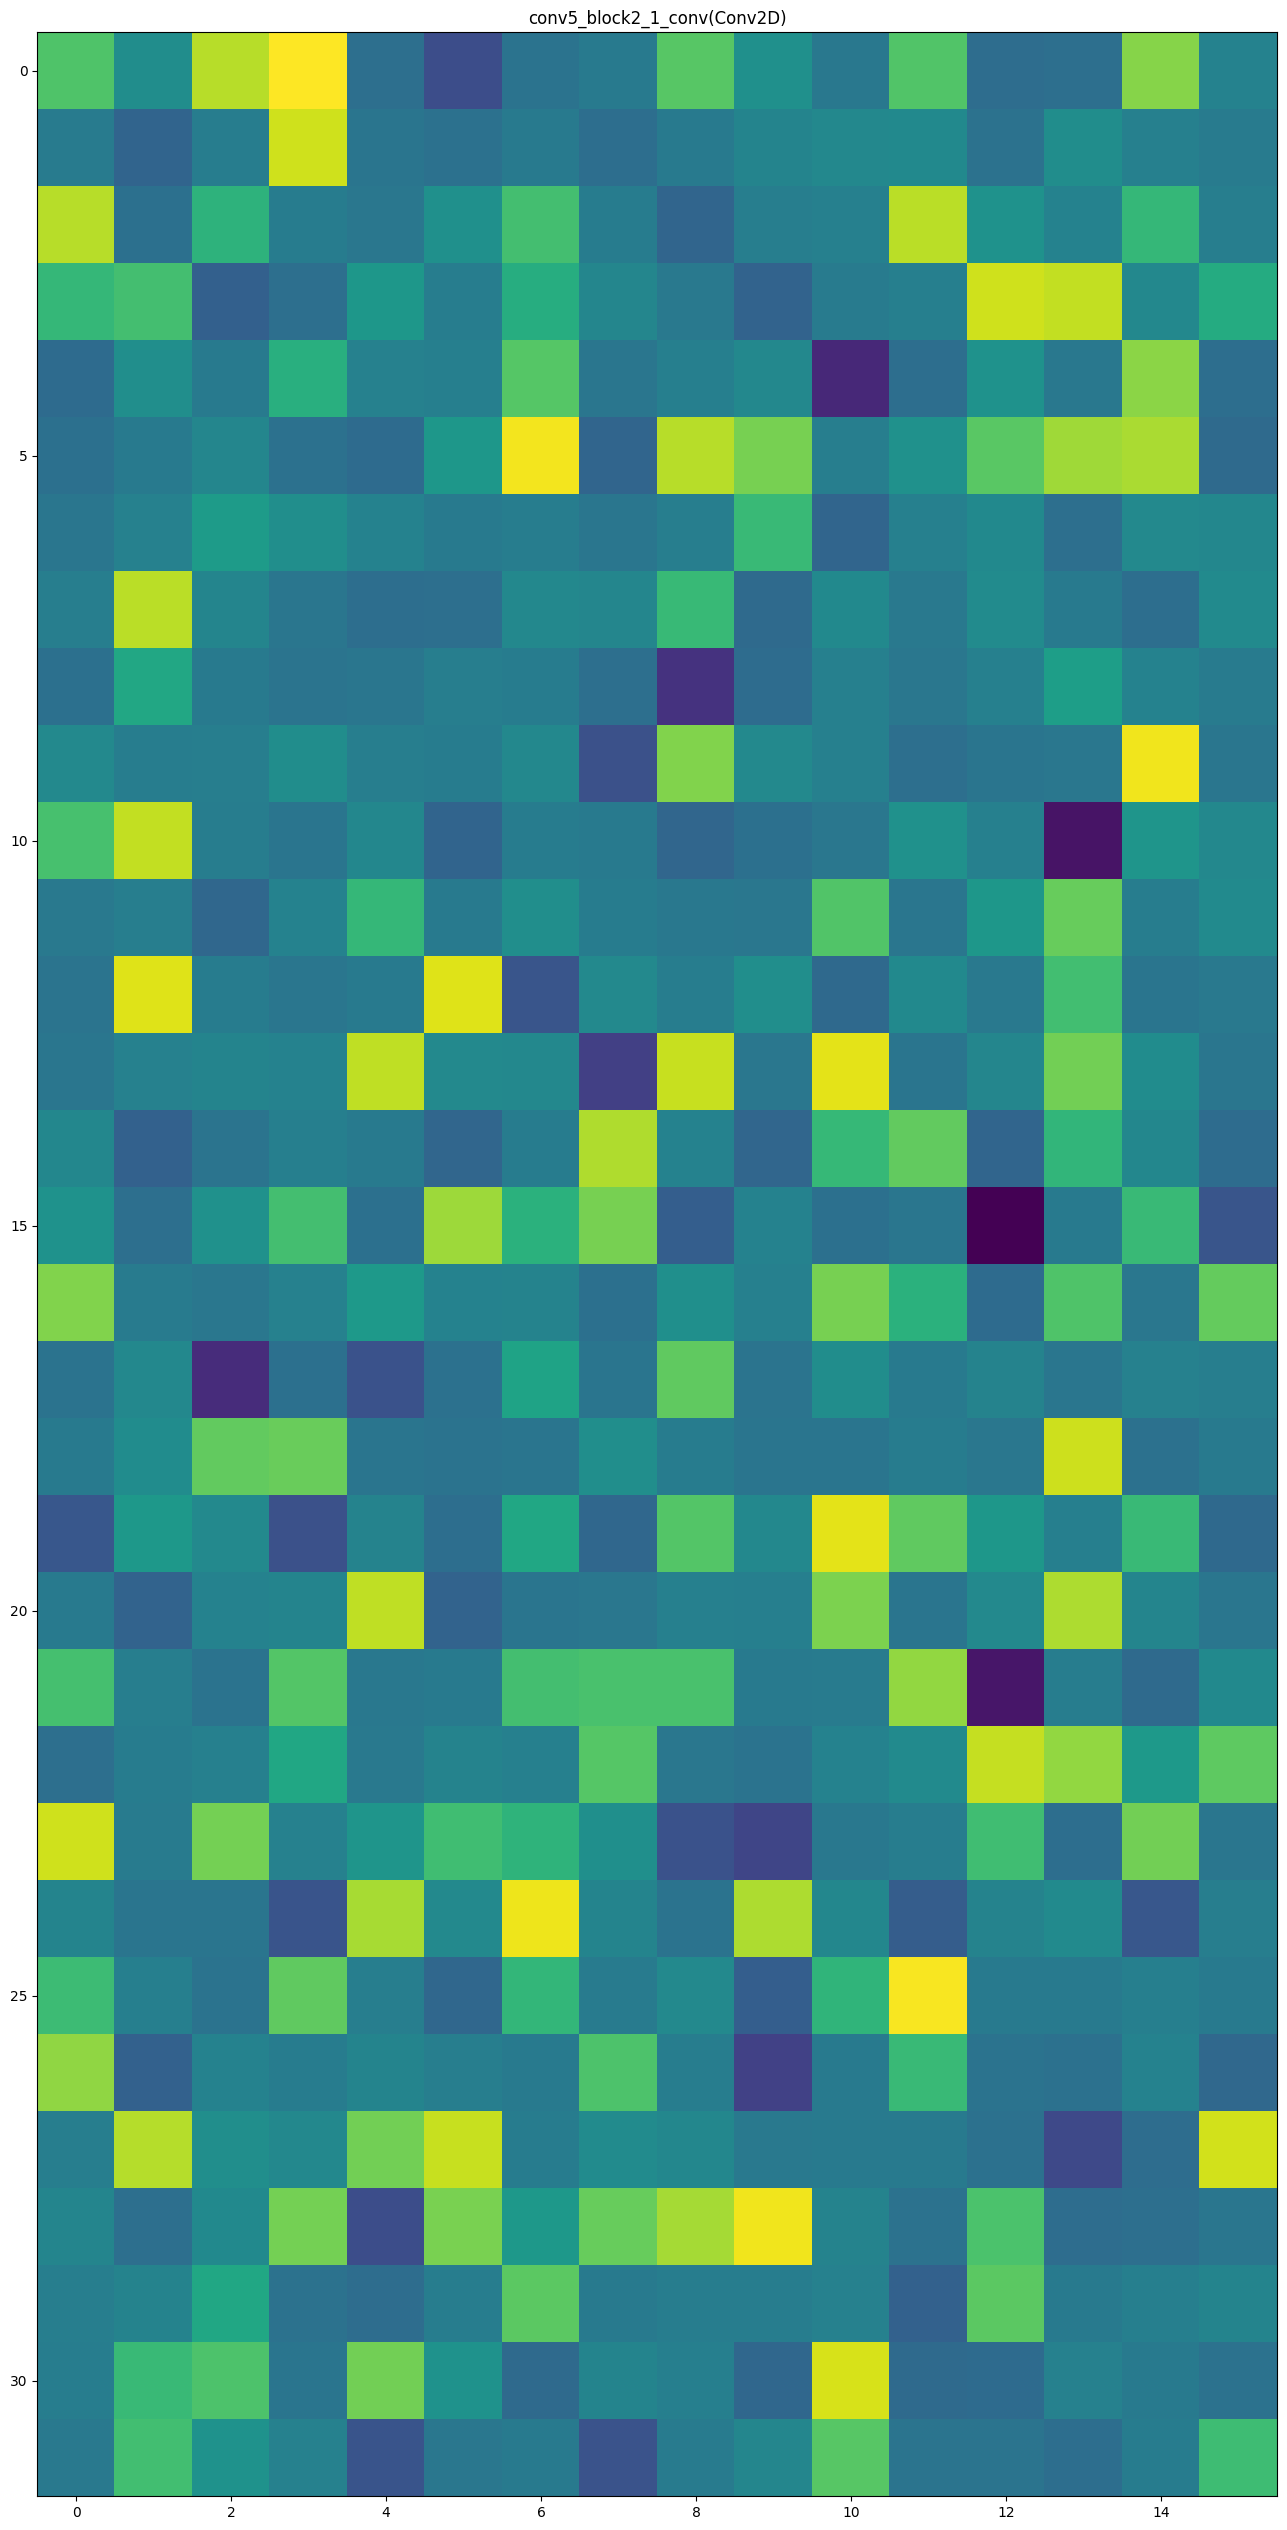

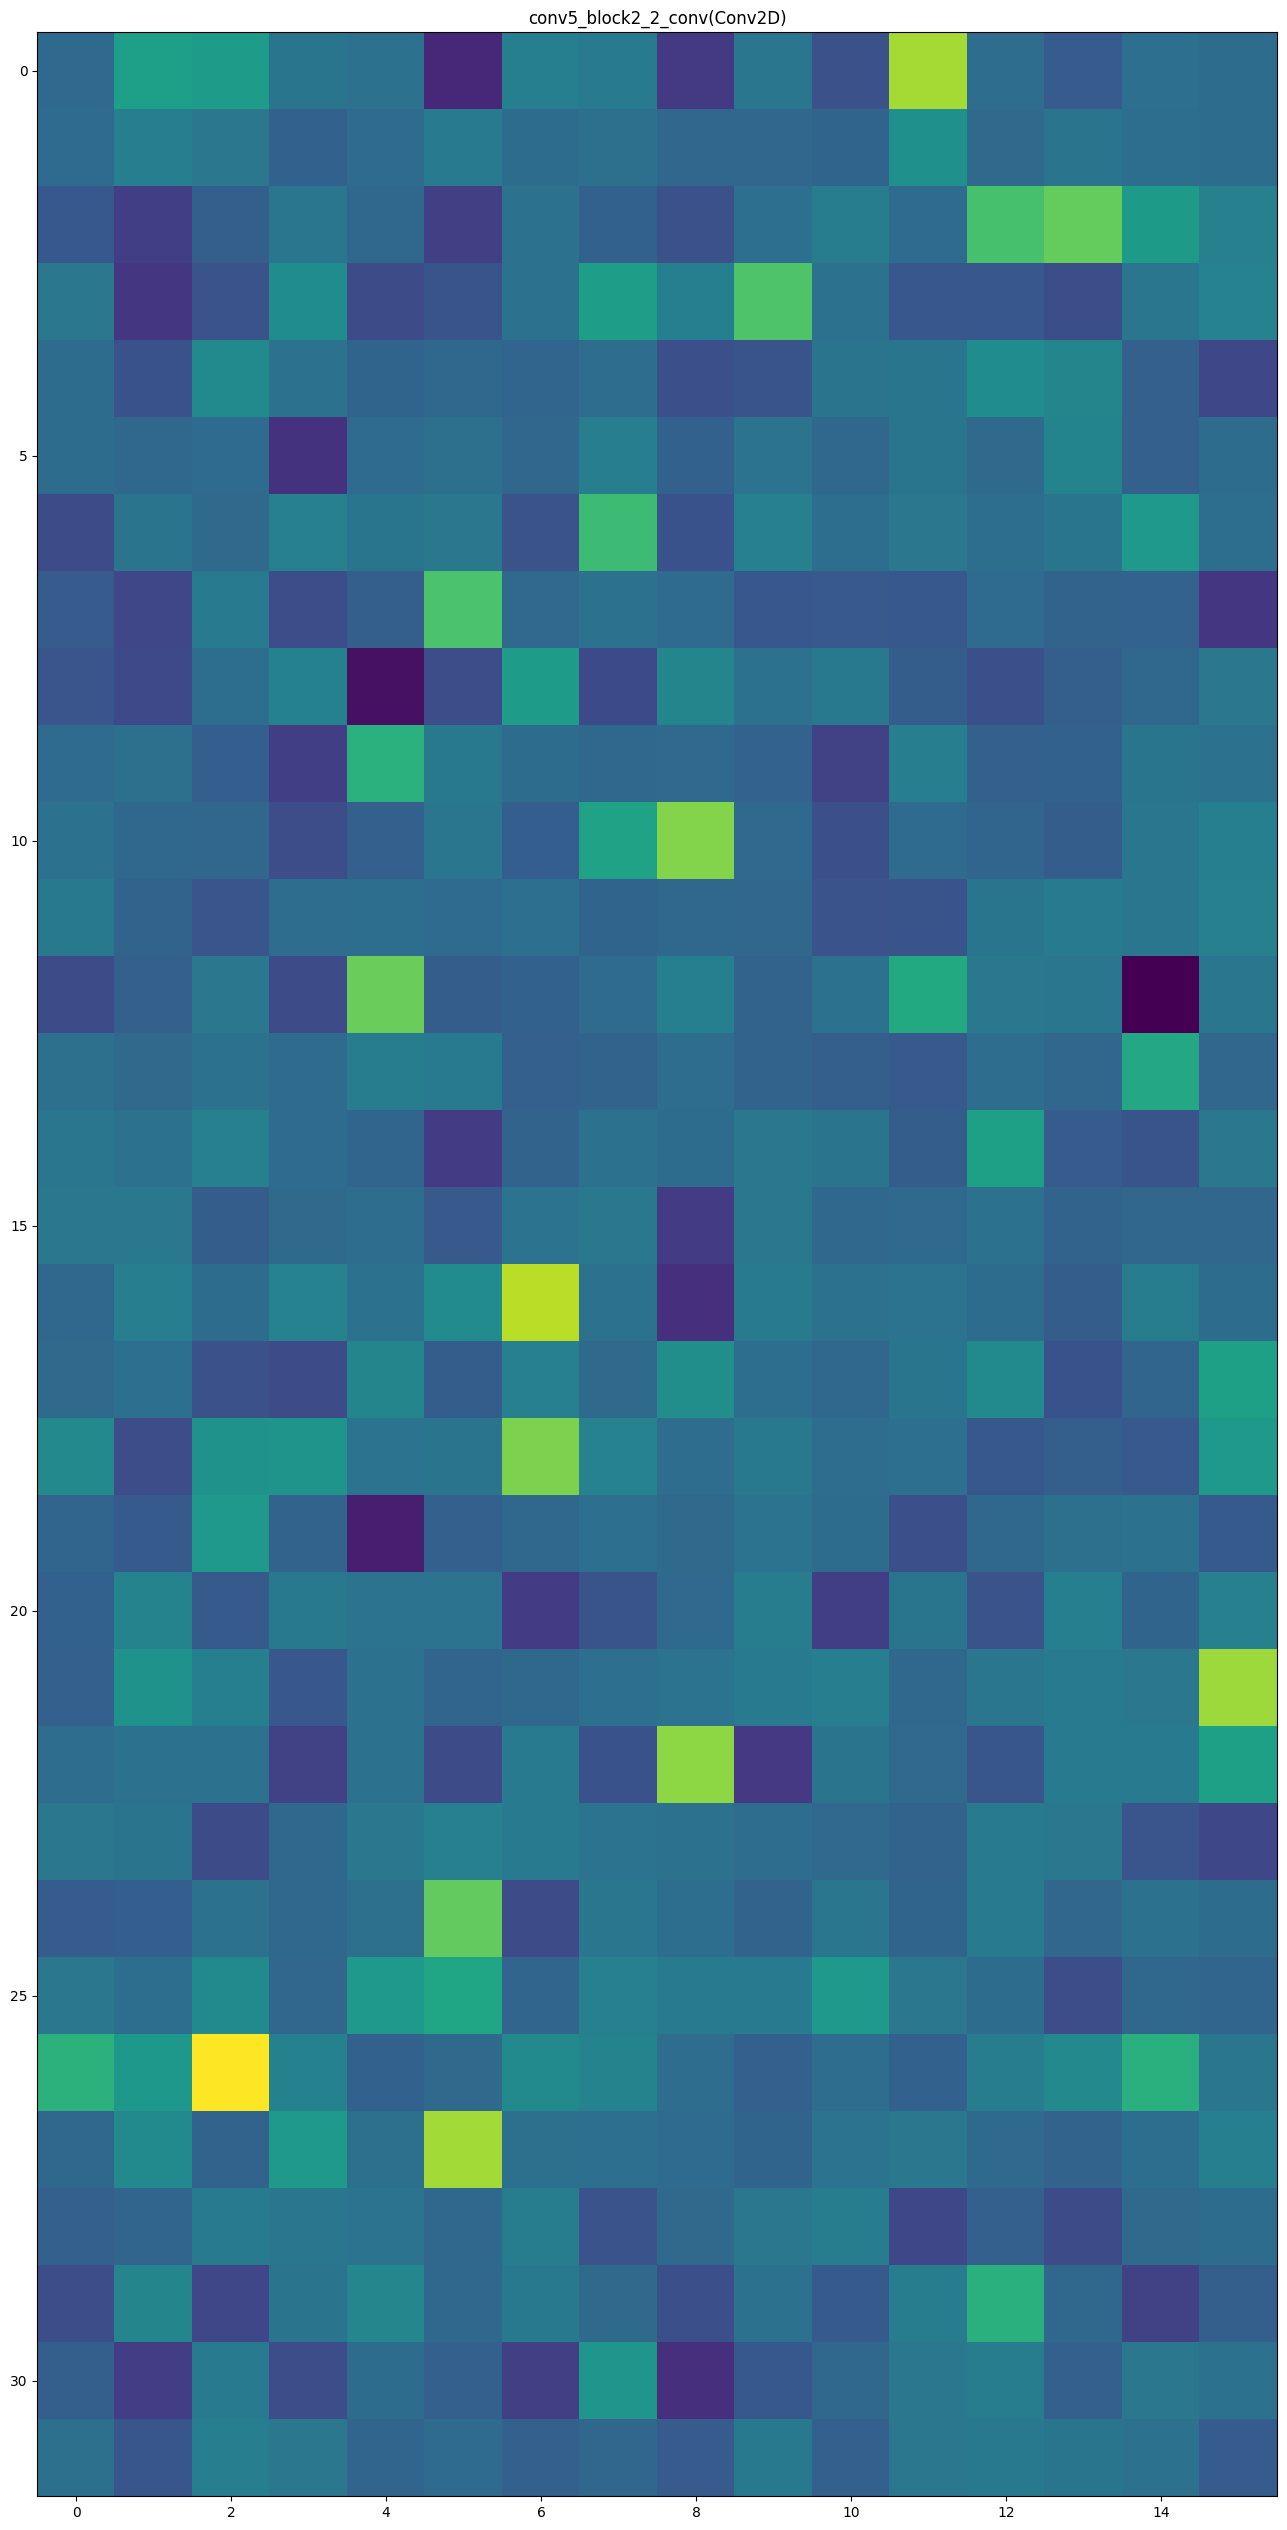

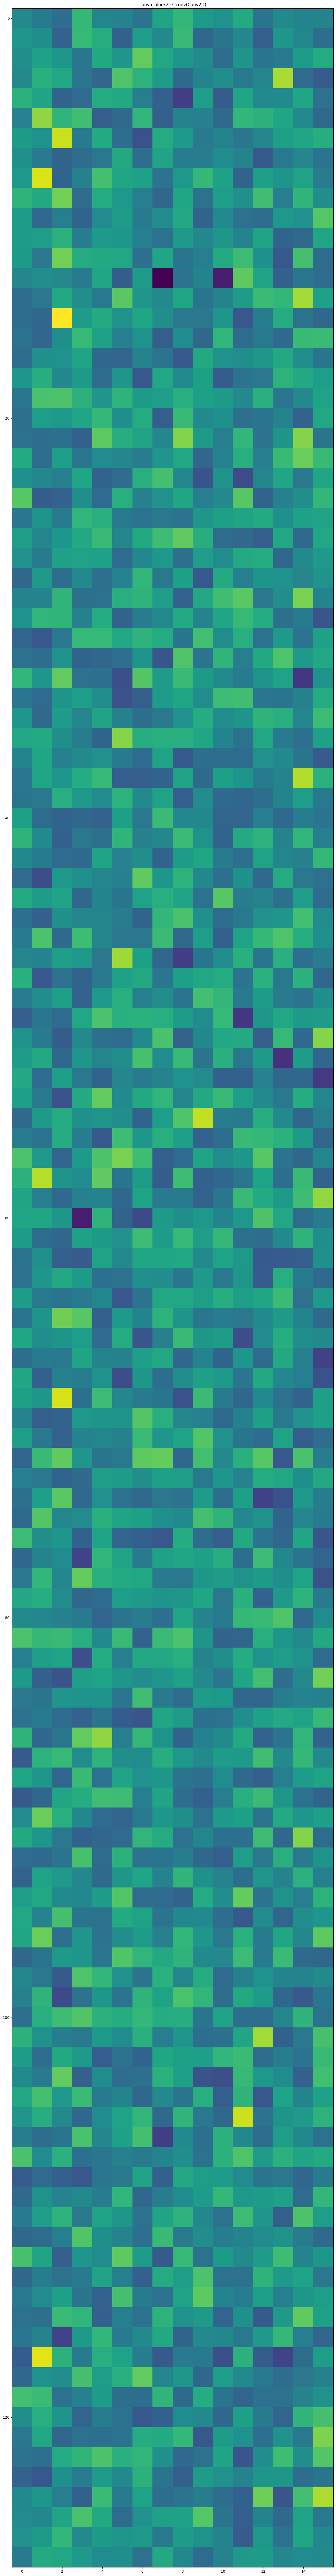

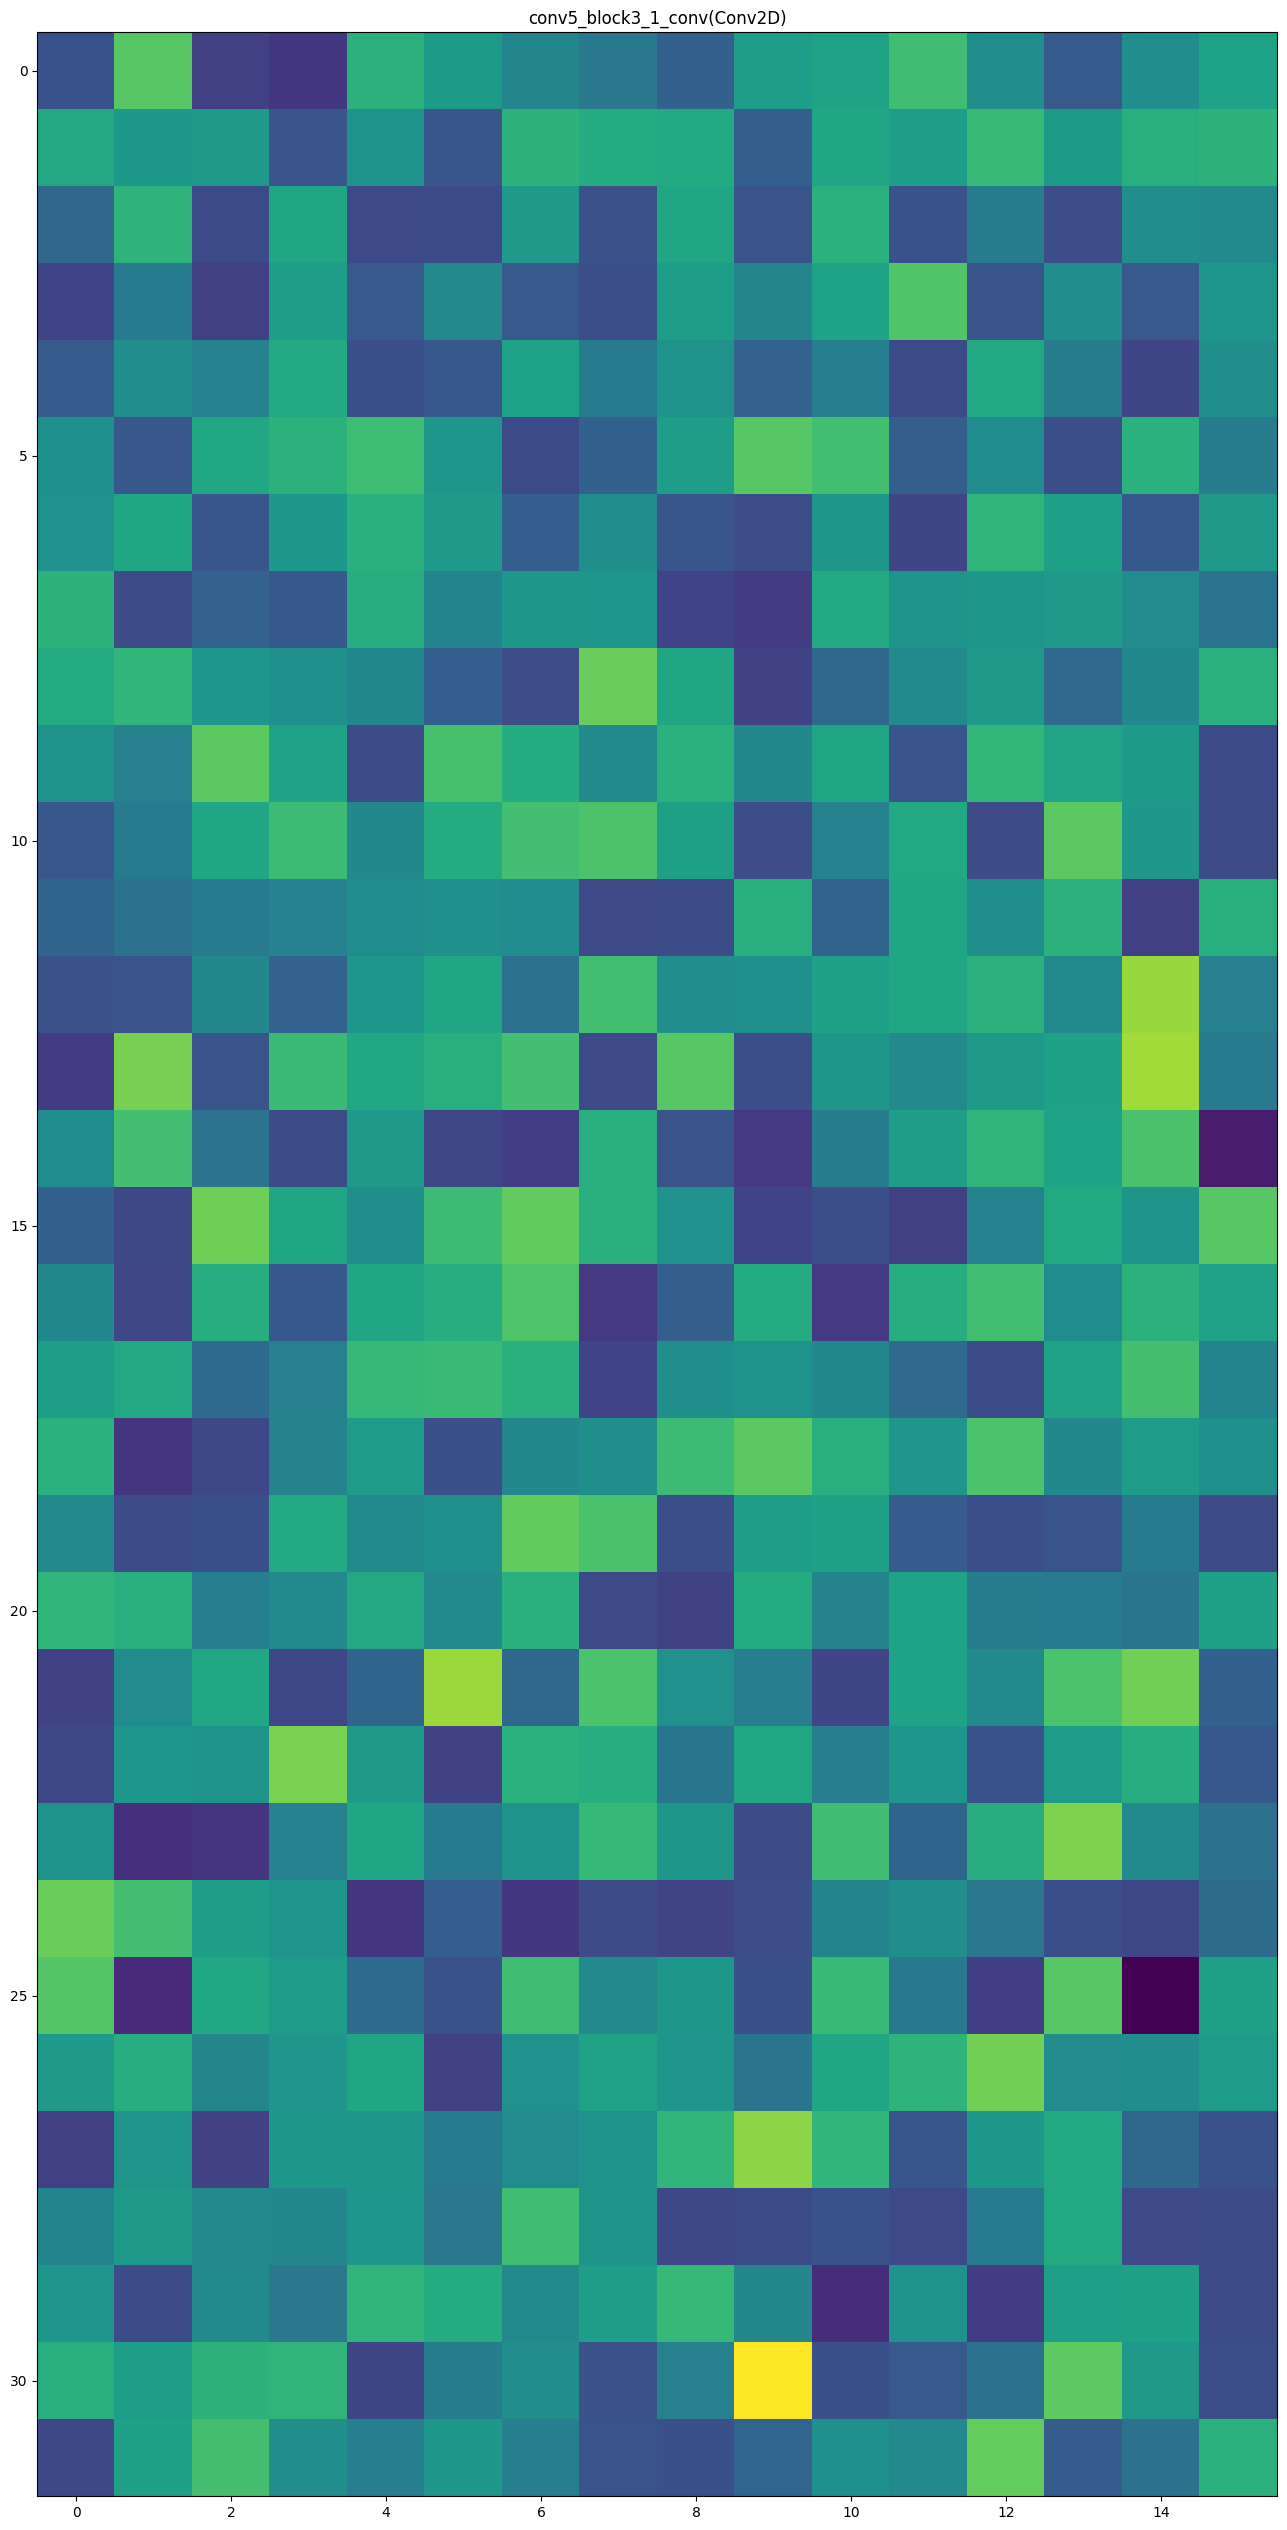

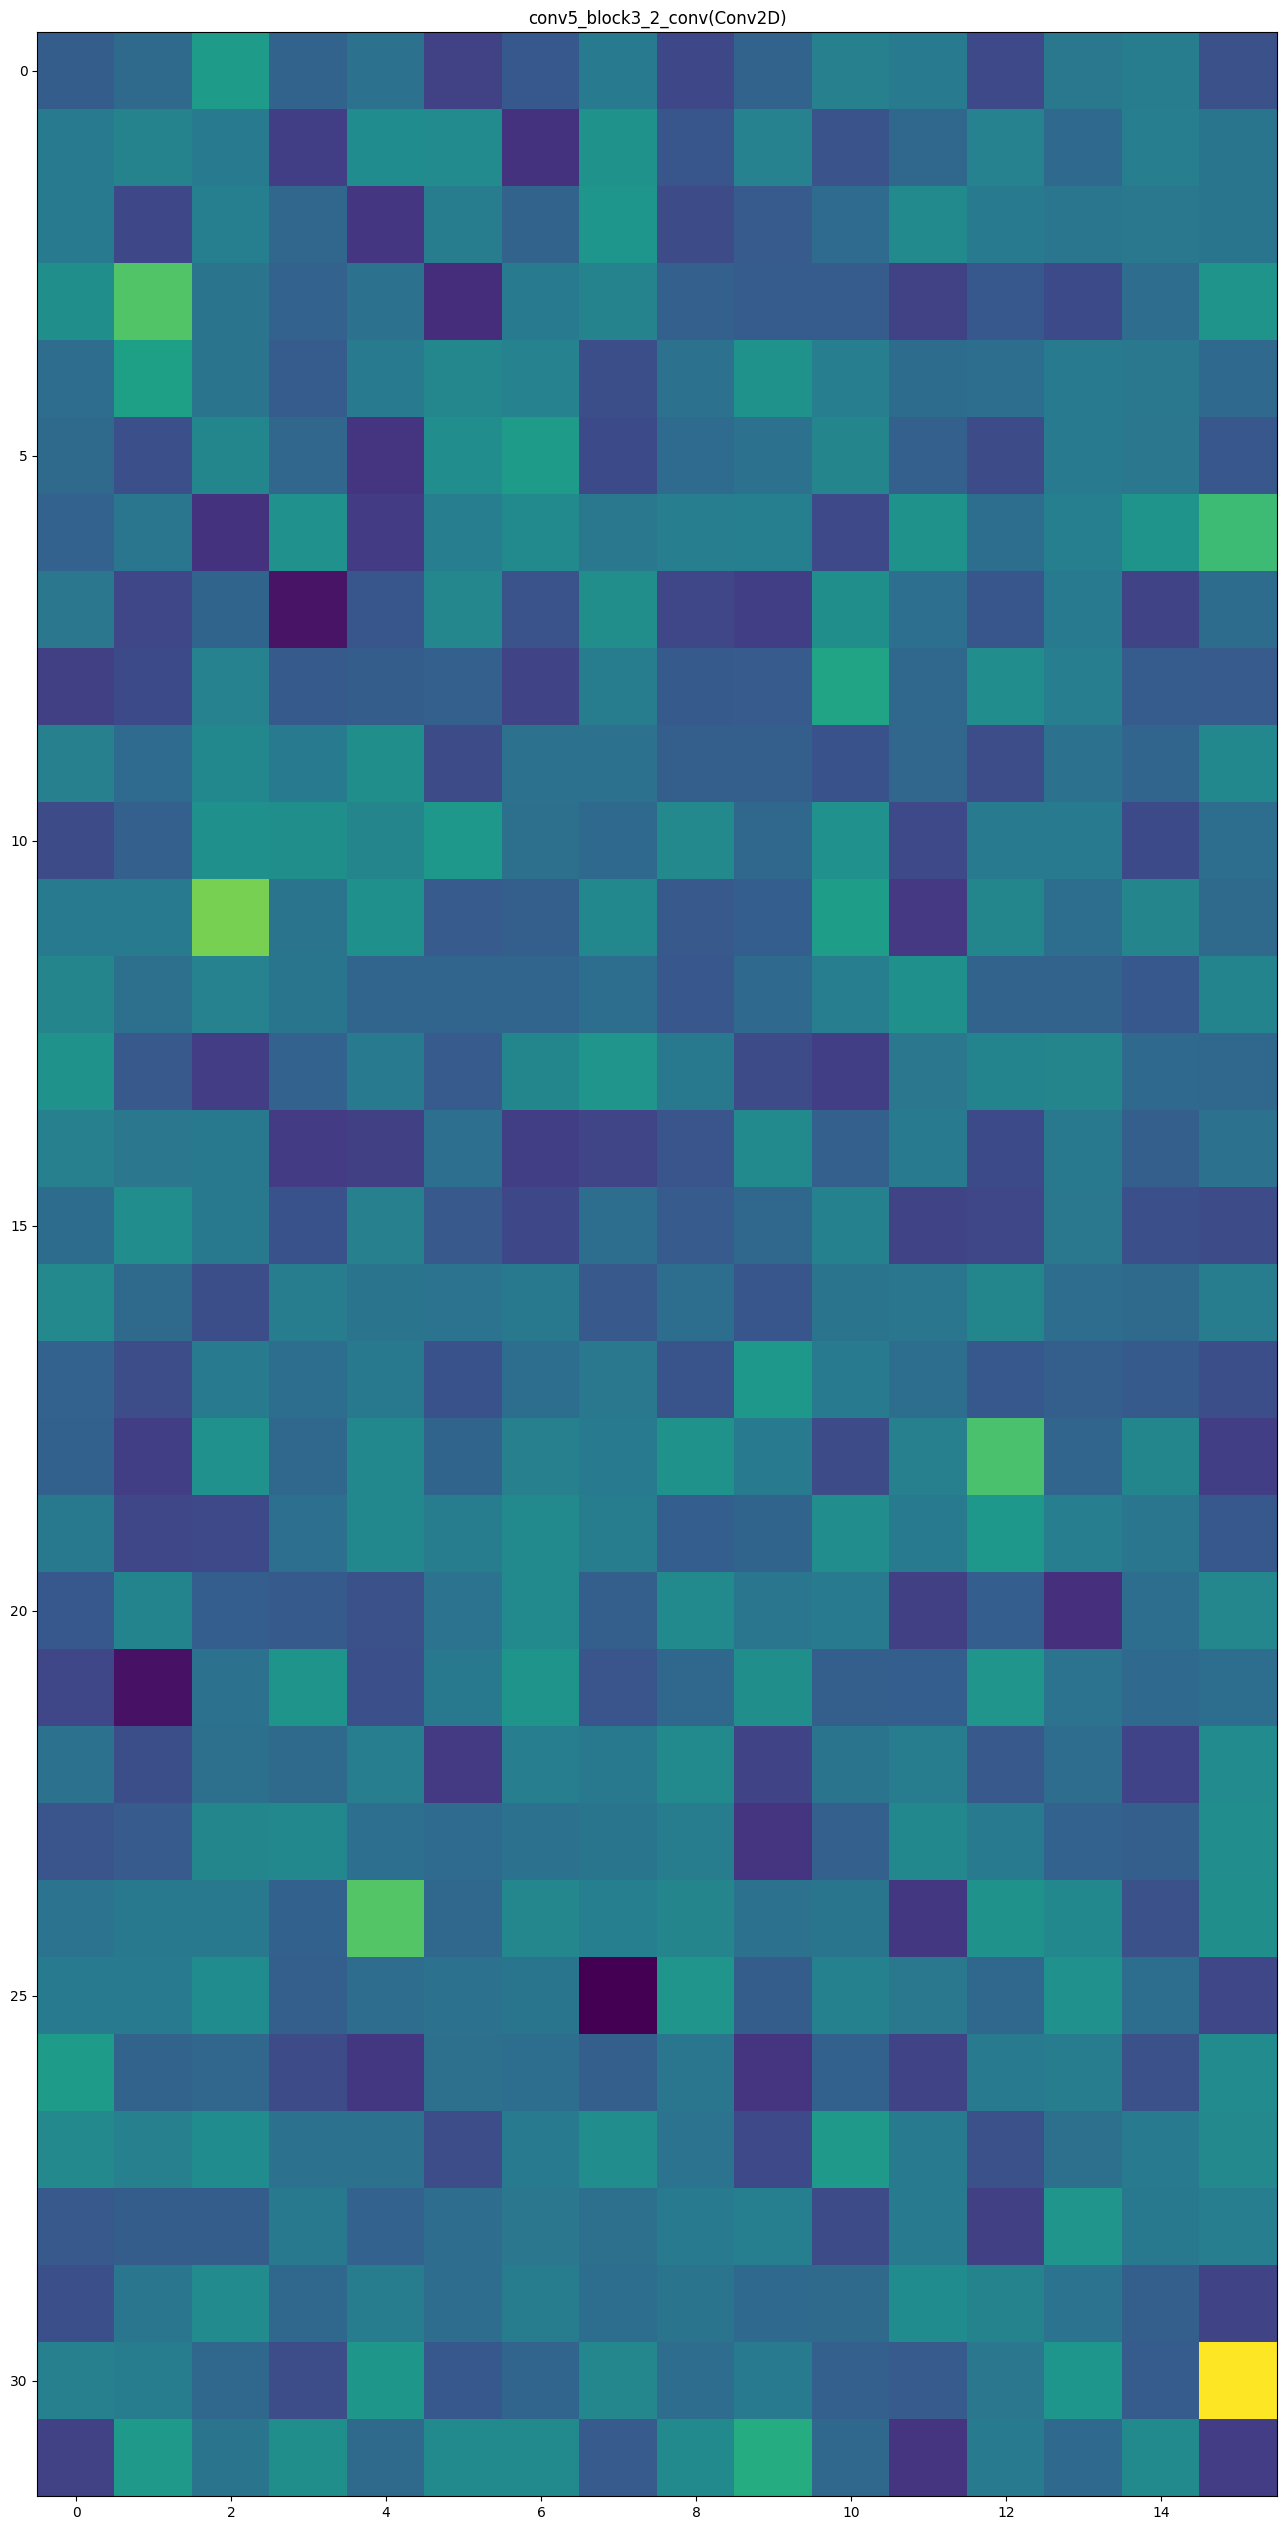

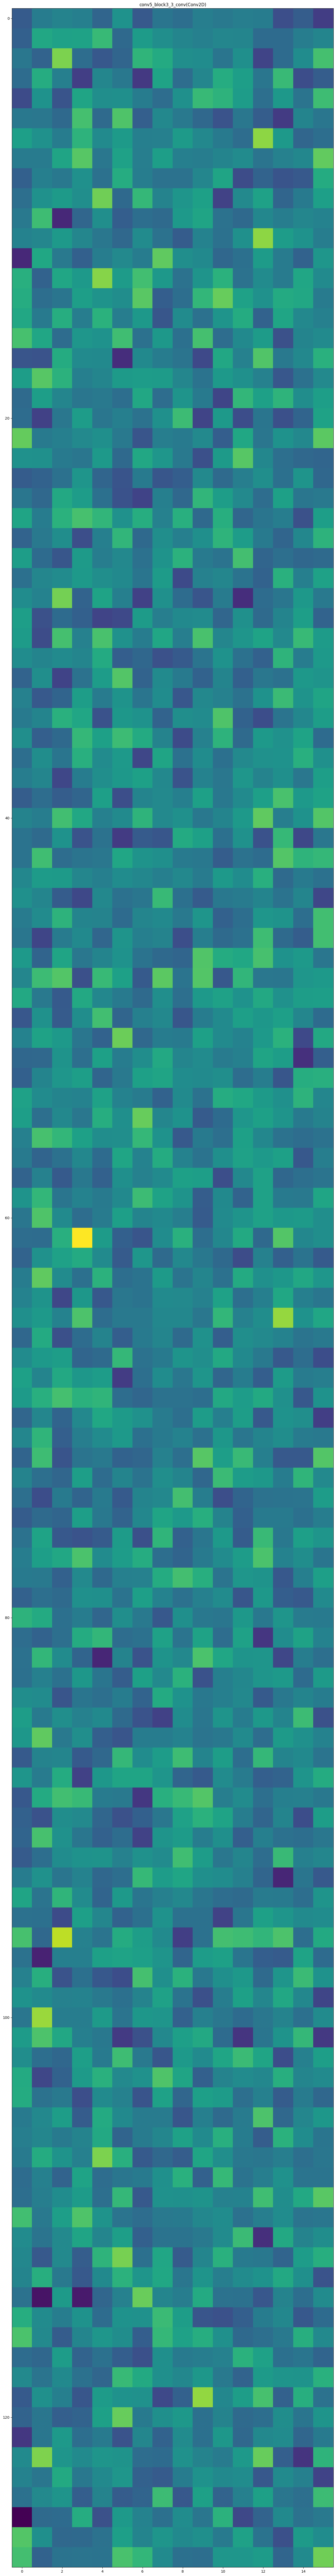

In [30]:
layer_names = get_layer_names(141, 172)

# Now let's display our feature maps

plot_feature_map(layer_names, activations)

#Visualizing convnets filters.

In [48]:
def get_filters(start, end, names):
  filters=[]
  layer = model.layers
  for i in range(start, end):
    if 'Conv2D' not in names[i-start]:
      filters.append([0])
    else:
      filter, biases = model.layers[i].get_weights()
      filters.append(filter)
  return filters

In [65]:
def plot_filters(layer_names, filters):
  images_per_row = 16
  for layer_name, filter in zip(layer_names, filters):
    if 'Conv2D' not in layer_name:
      continue

    fig1=plt.figure(figsize=(8, 12))
    fig1.suptitle(layer_name)

    n_filters = filter.shape[3]
    columns = 16
    rows = int(n_filters/columns)

    for i in range(1, n_filters +1):
        f = filter[:, :, :, i-1]
        fig1 =plt.subplot(rows, columns, i)
        fig1.set_xticks([])  #Turn off axis
        fig1.set_yticks([])
        plt.imshow(f[:, :, 0], cmap='gray') #Show only the filters from 0th channel (R)
        #ix += 1


  plt.show()

conv1_conv(Conv2D) (7, 7, 3, 64)


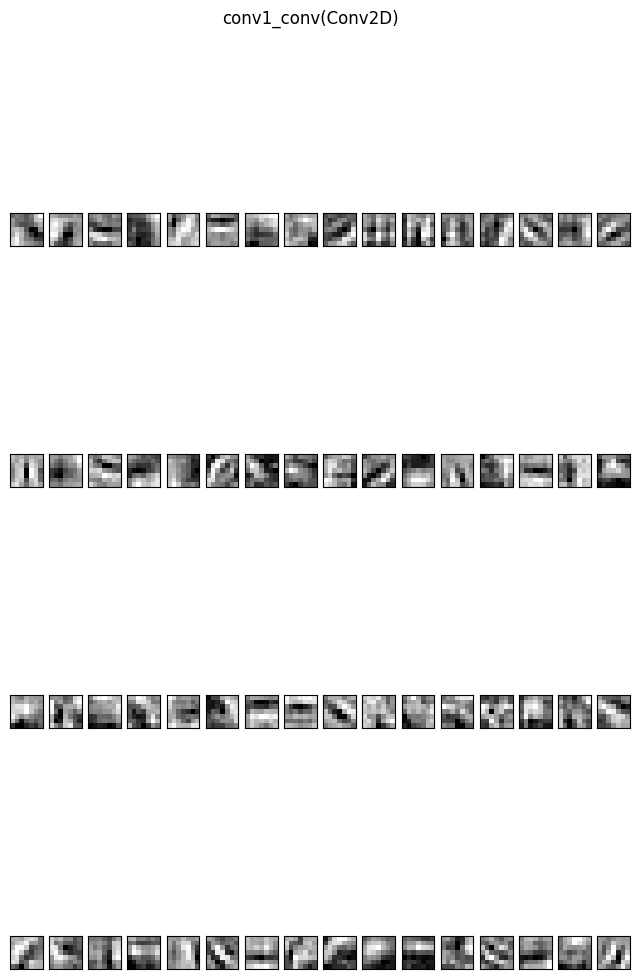

In [64]:
layer_names = get_layer_names(0, 6)
filters = get_filters(0, 6, layer_names)
plot_filters(layer_names, filters)

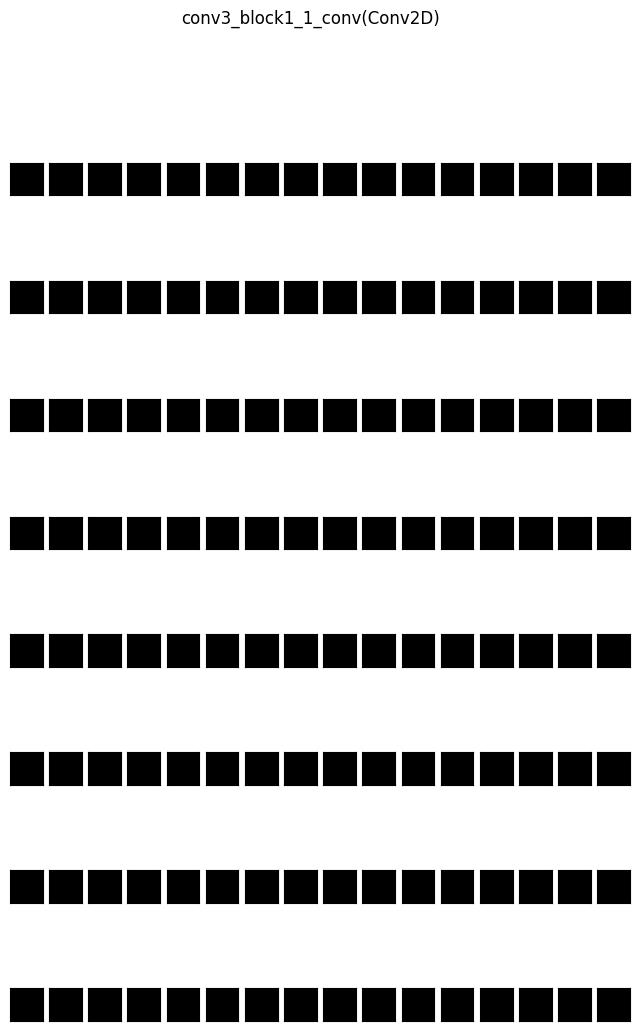

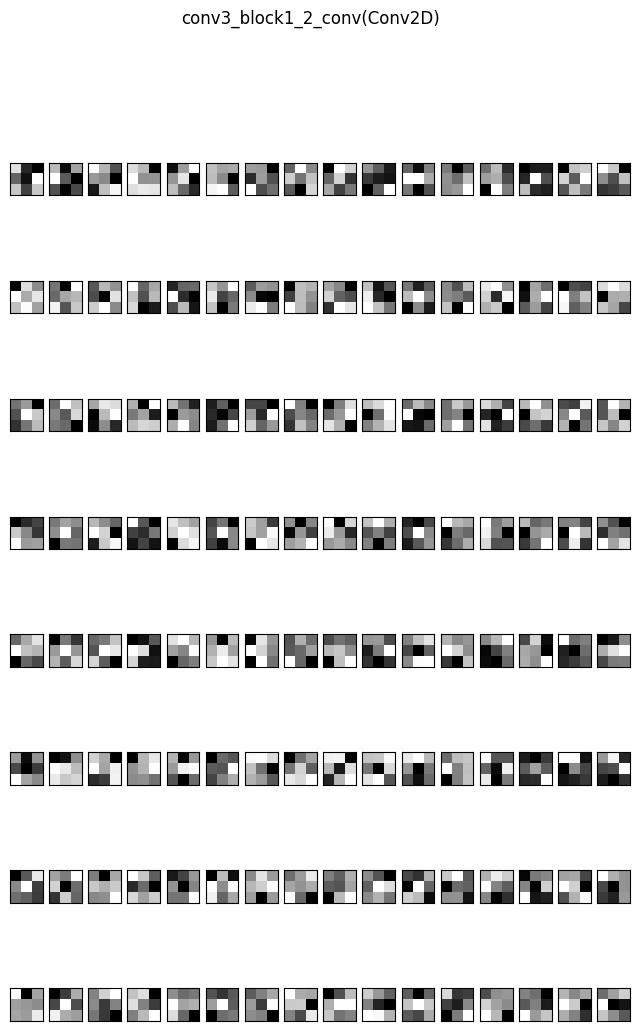

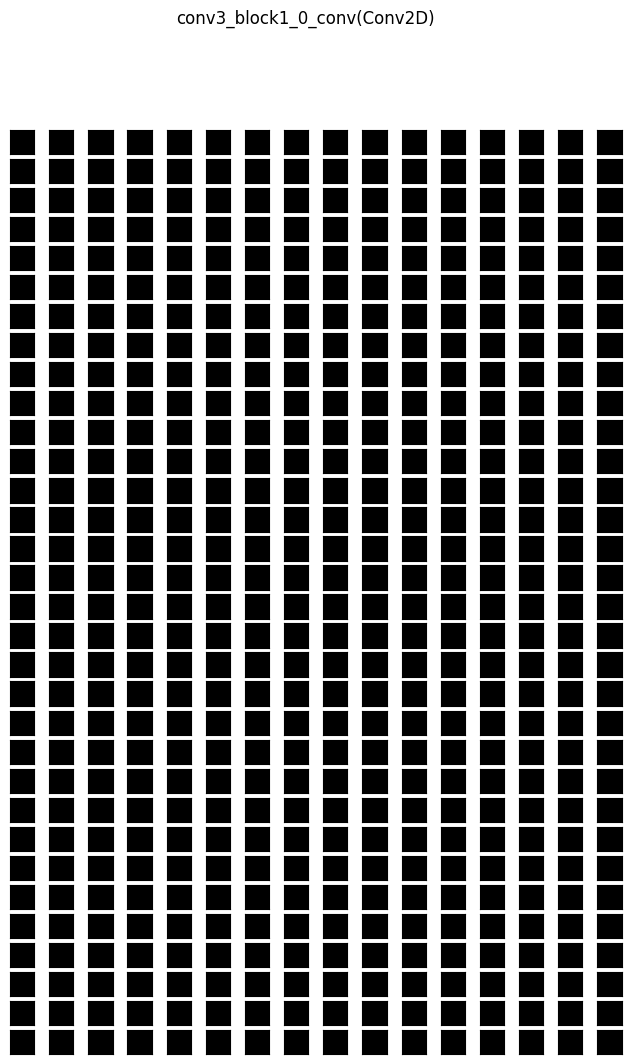

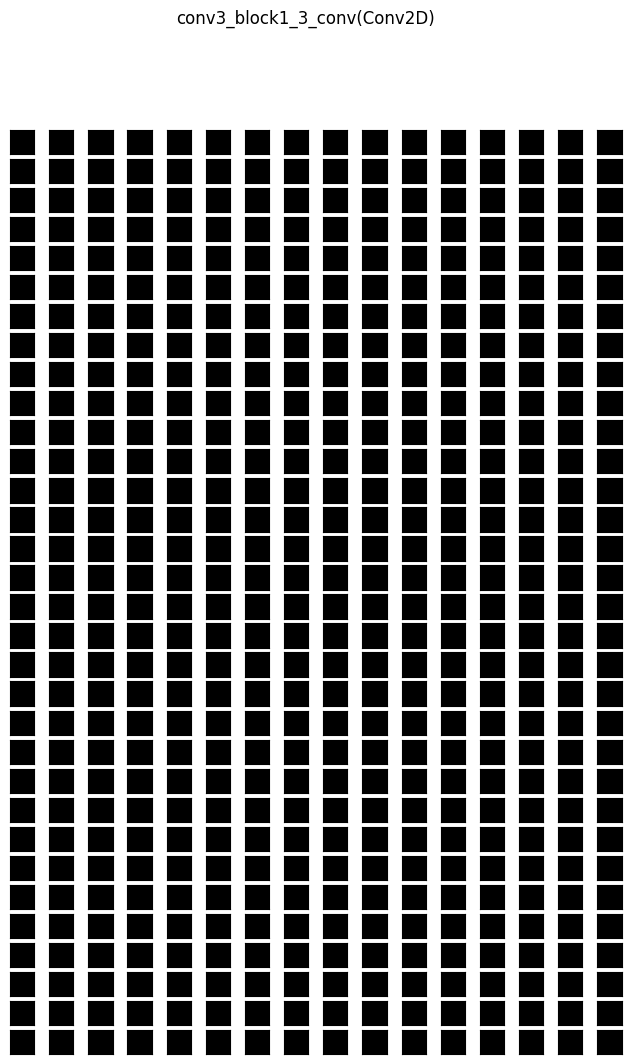

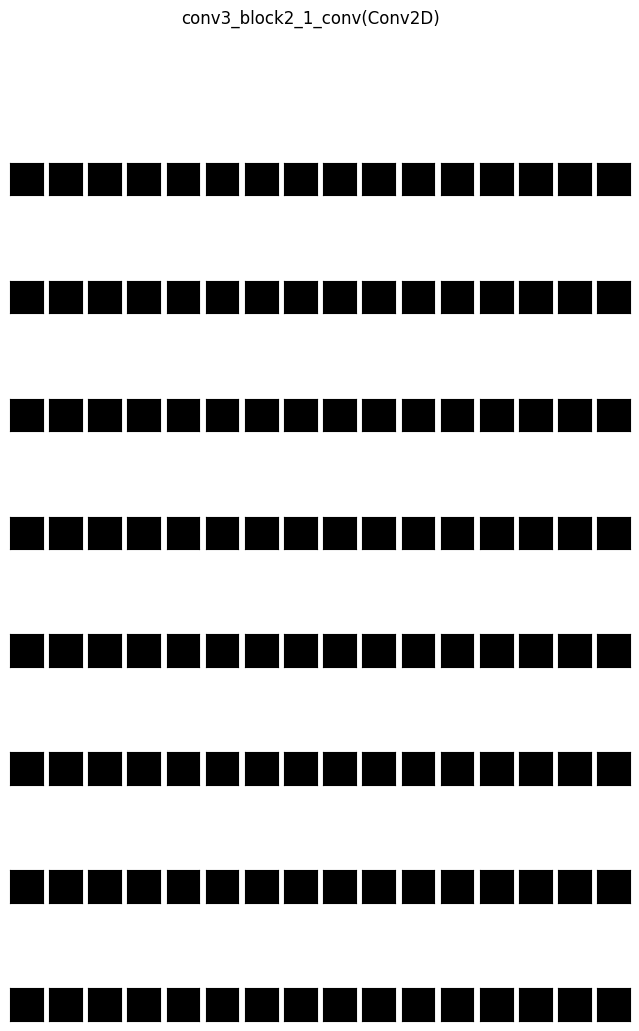

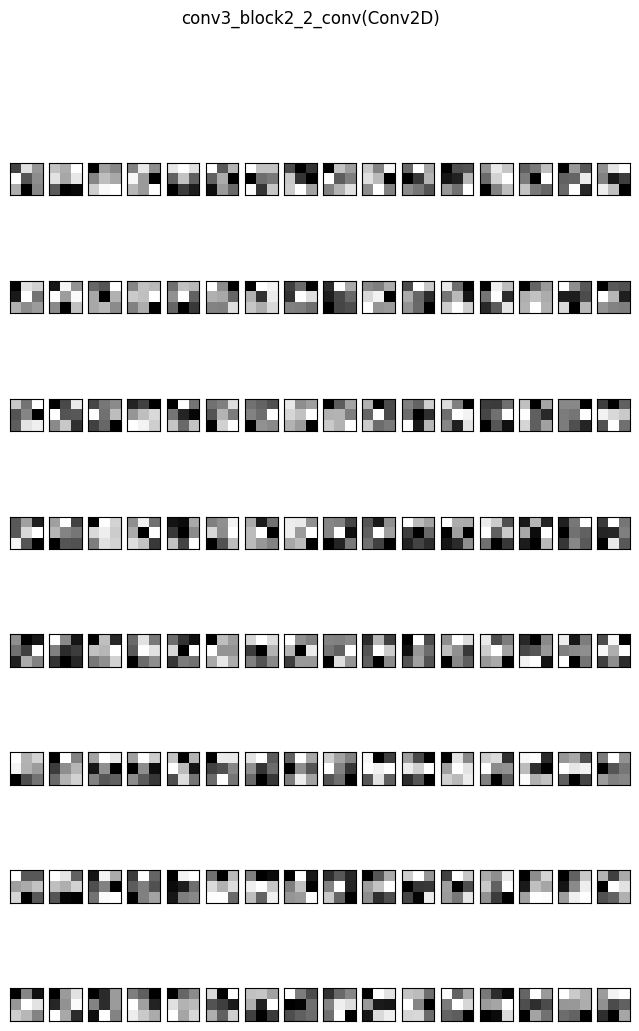

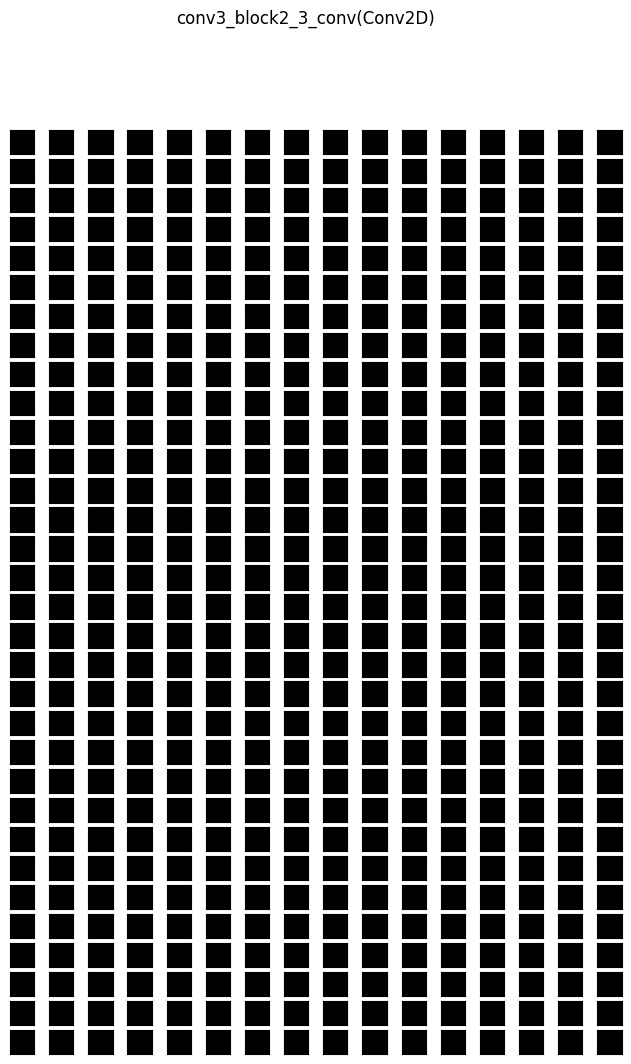

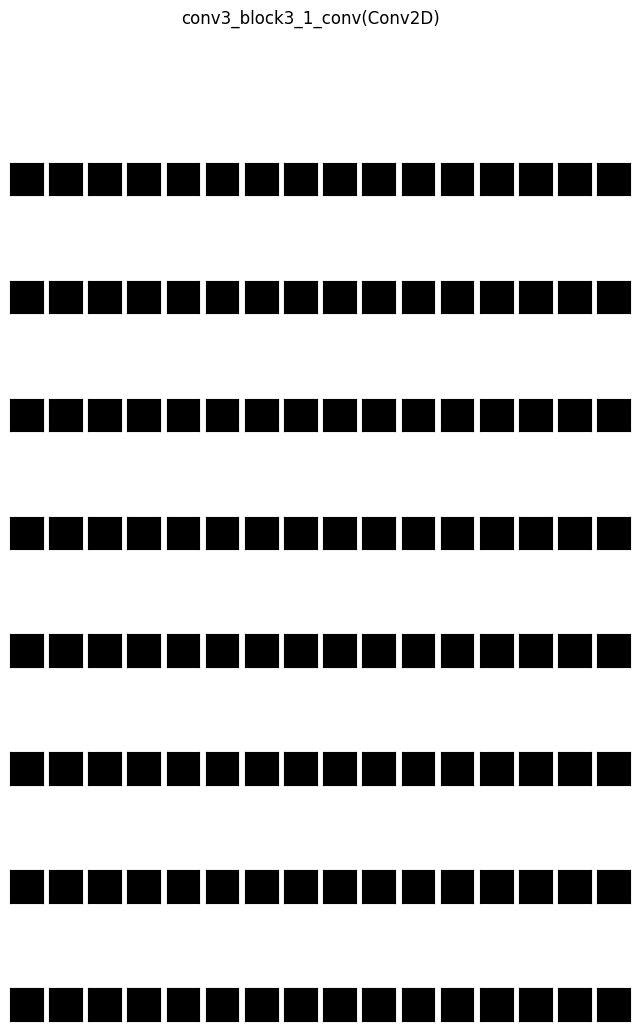

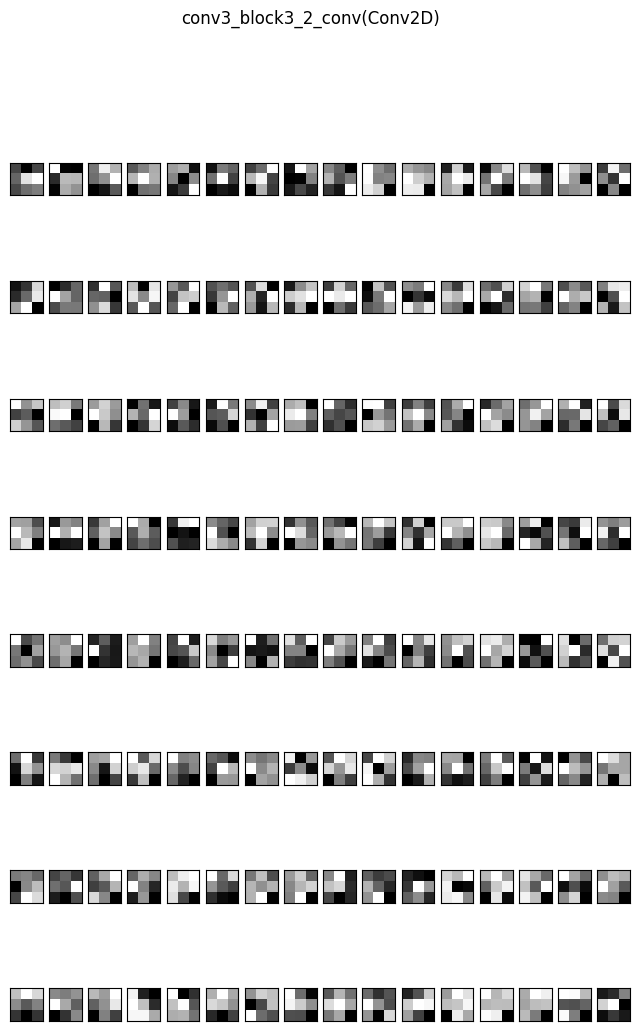

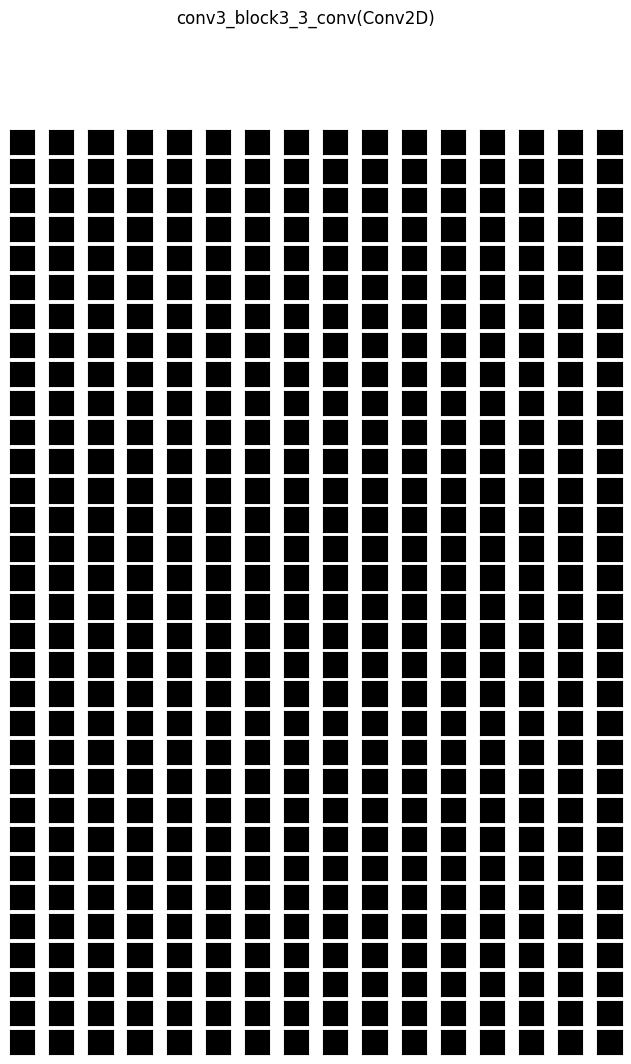

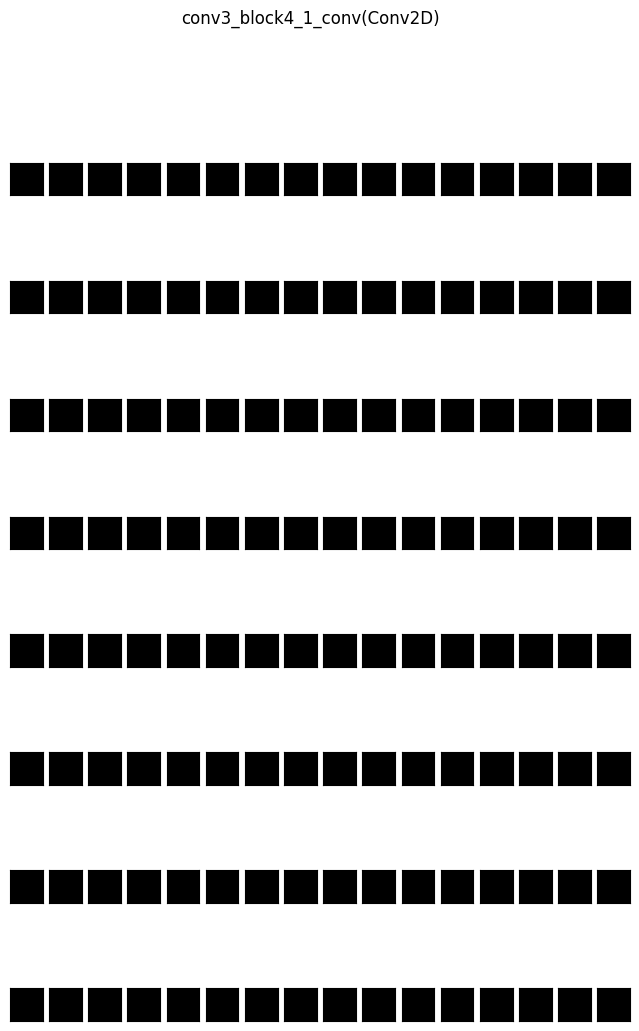

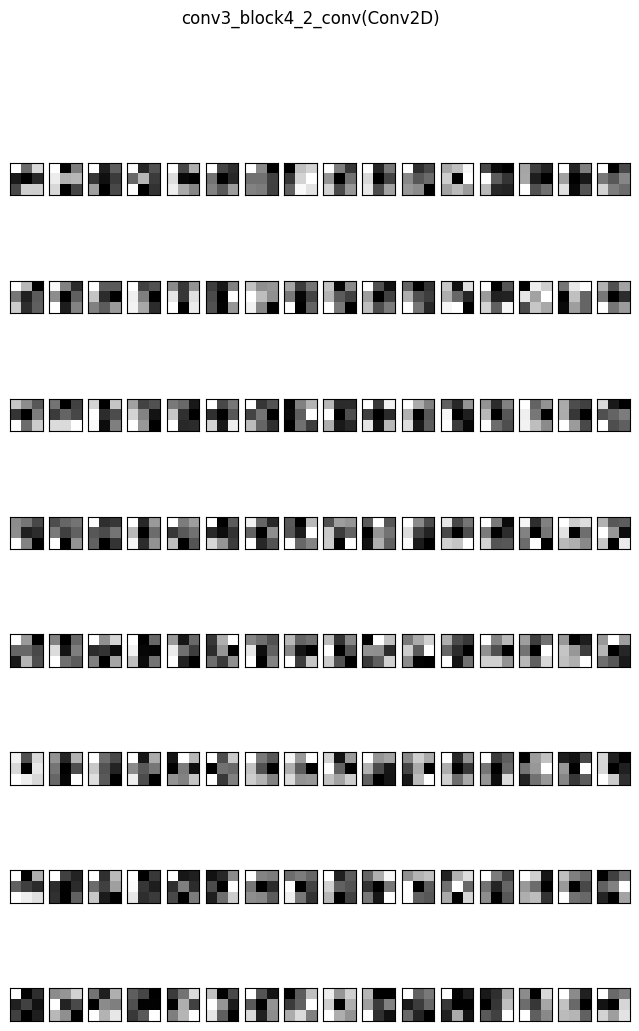

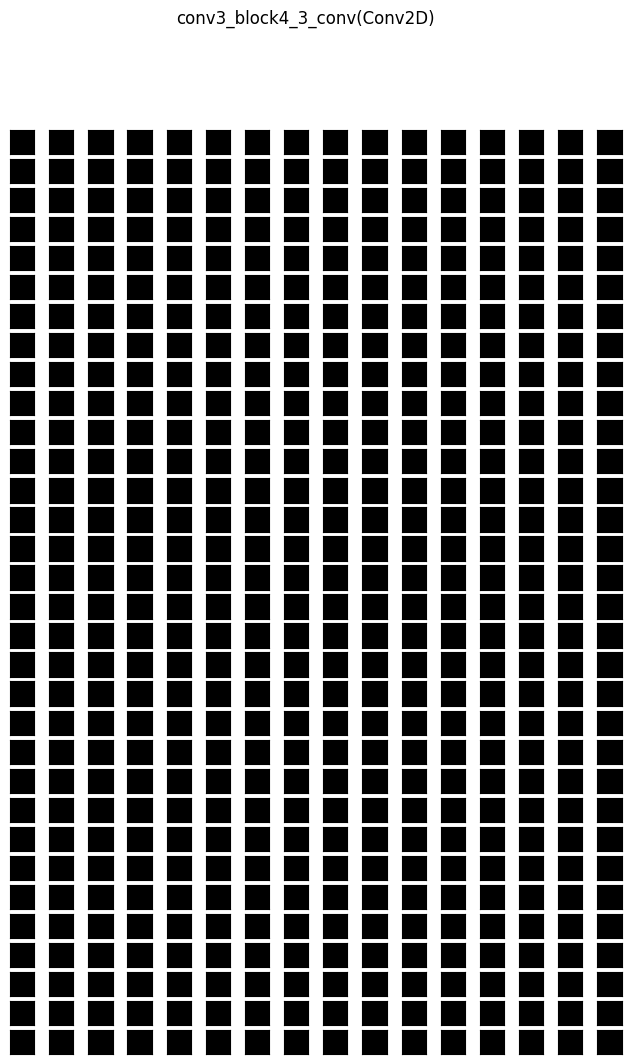

In [67]:
layer_names = get_layer_names(38, 78)
filters = get_filters(38, 78, layer_names)
plot_filters(layer_names, filters)

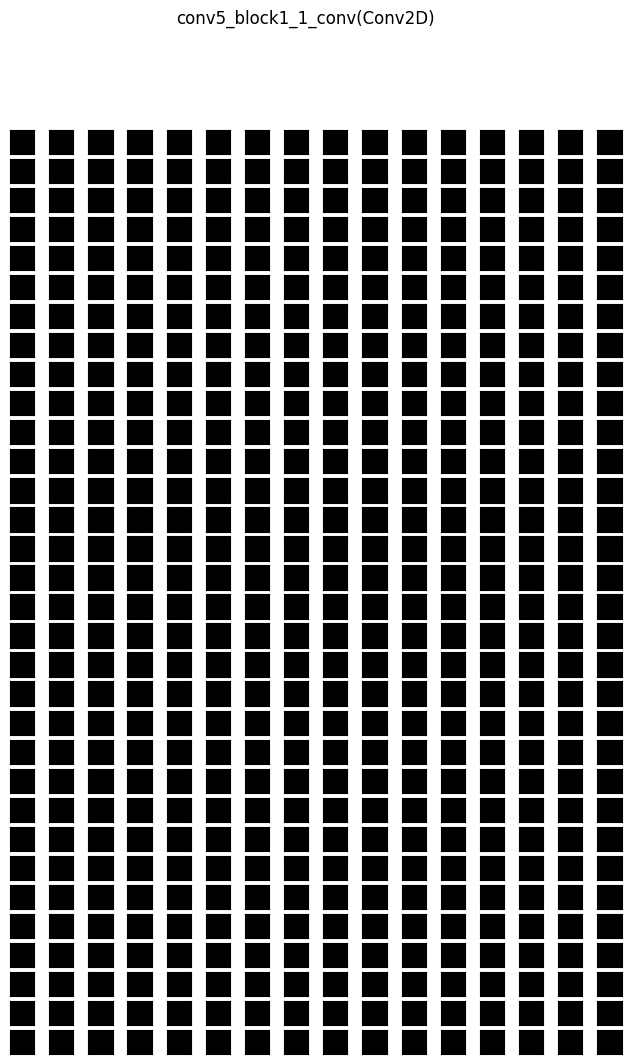

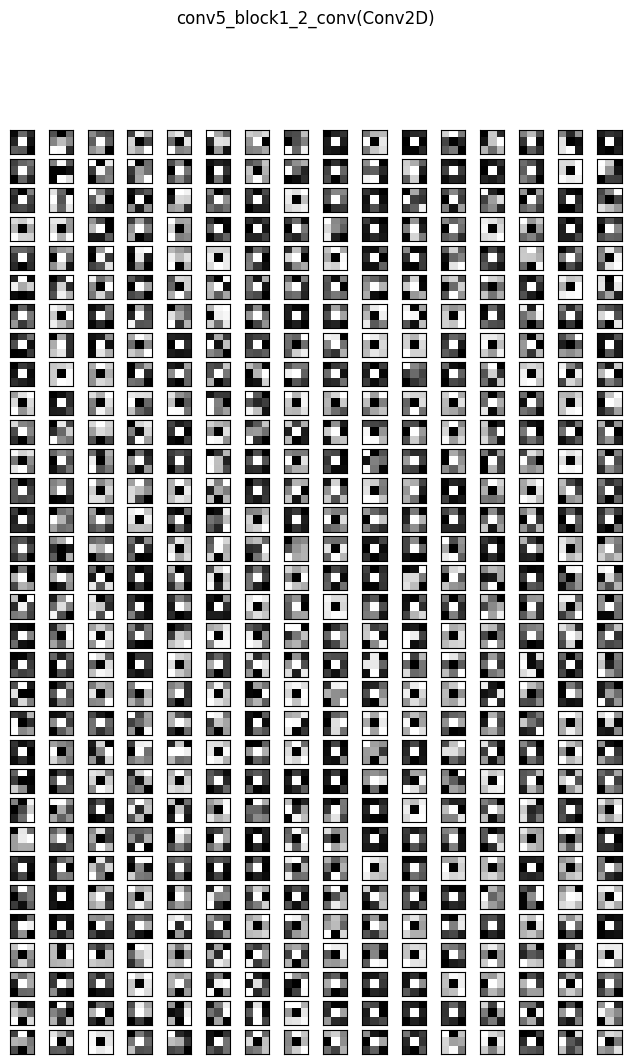

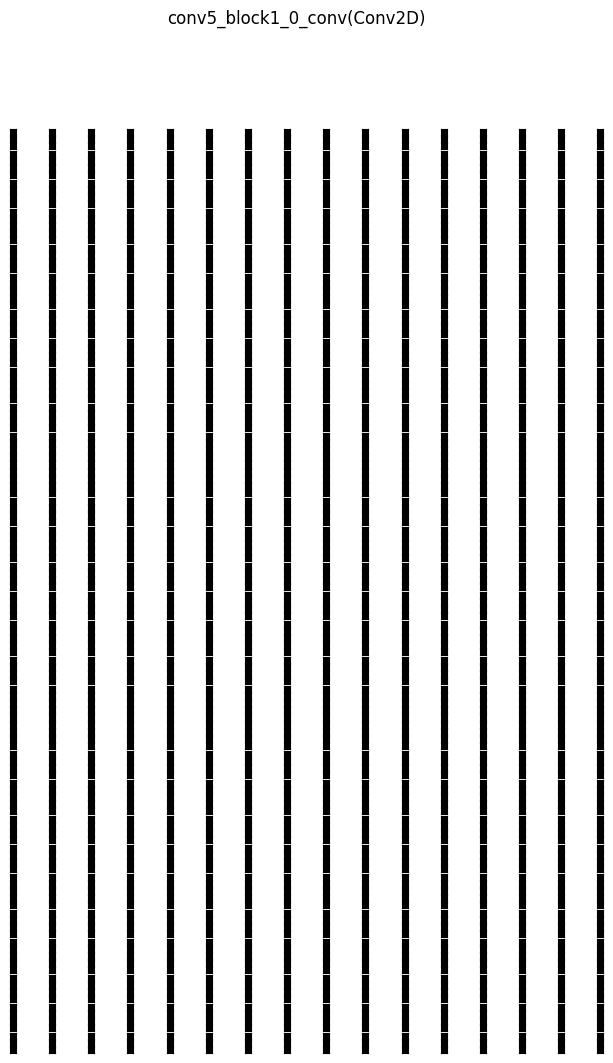

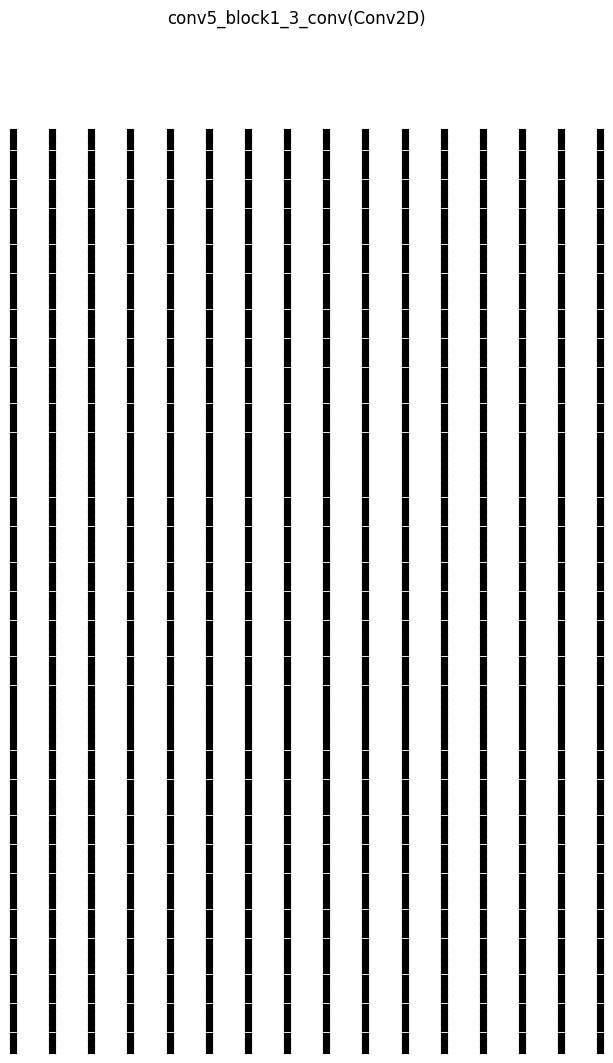

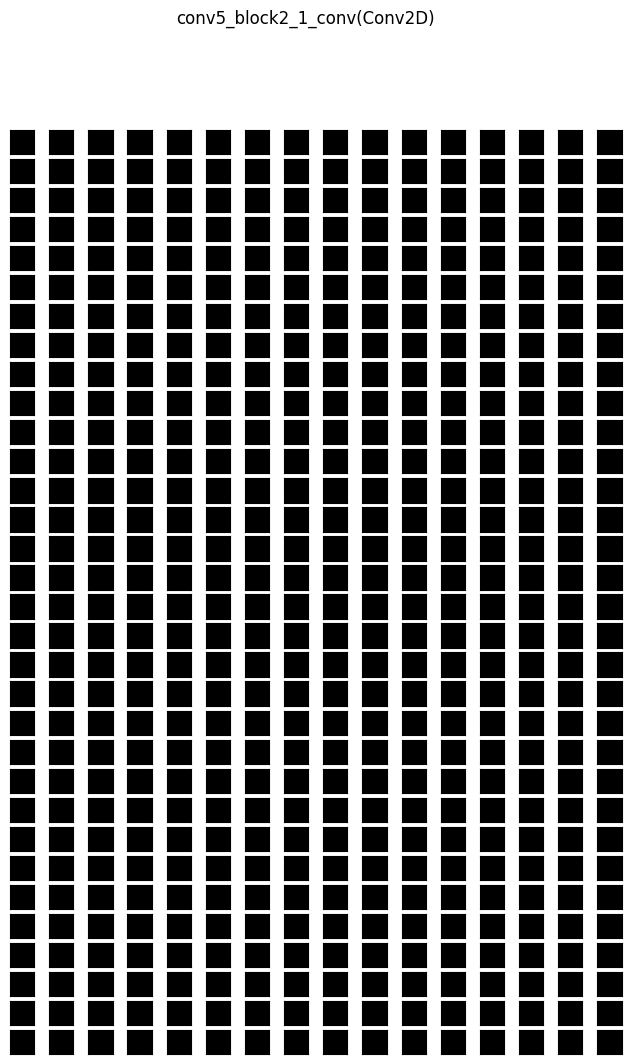

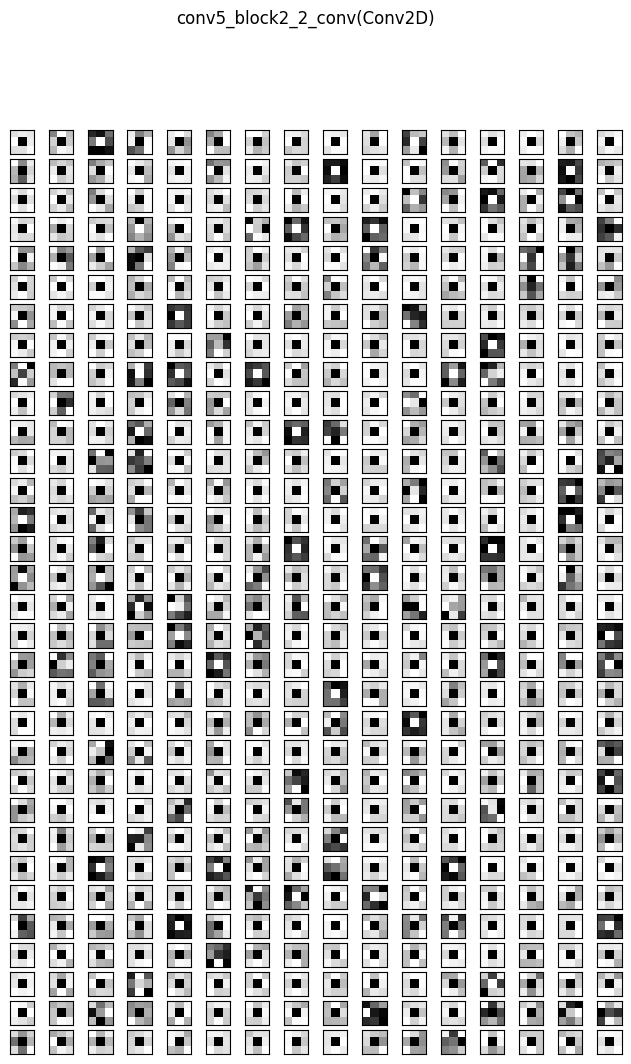

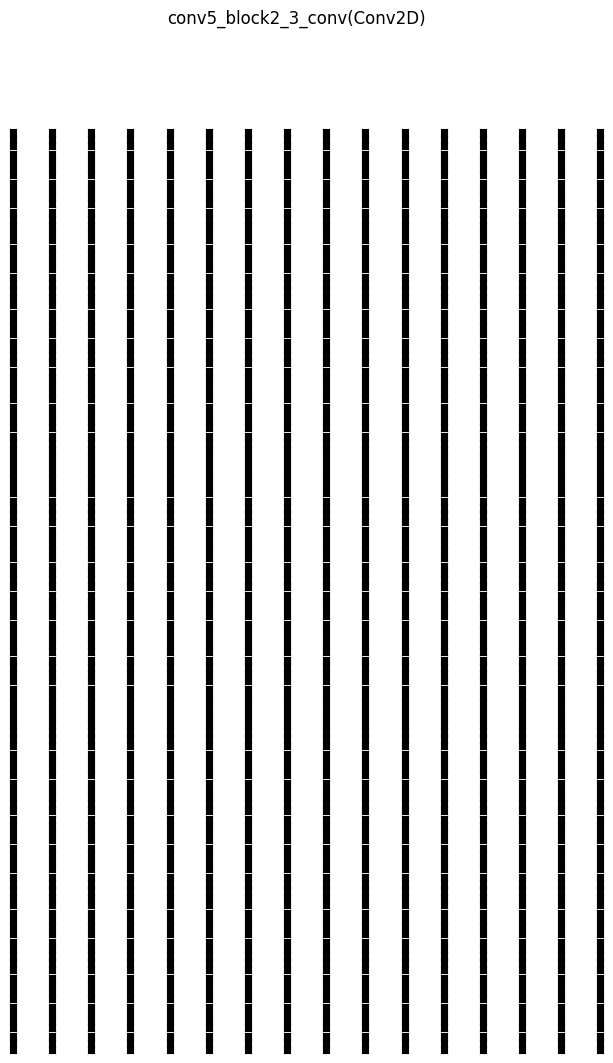

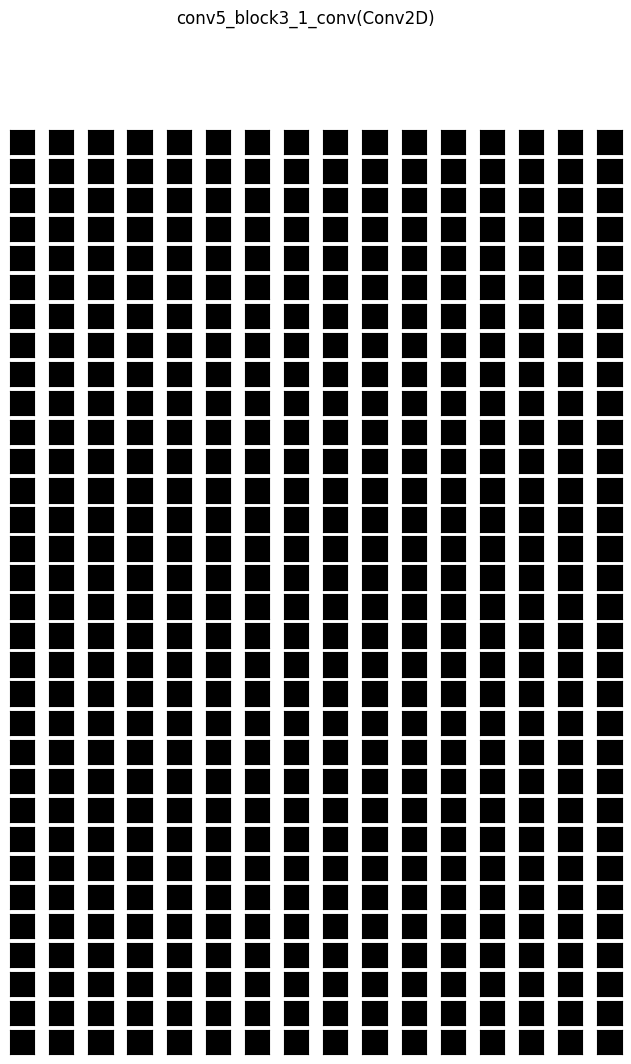

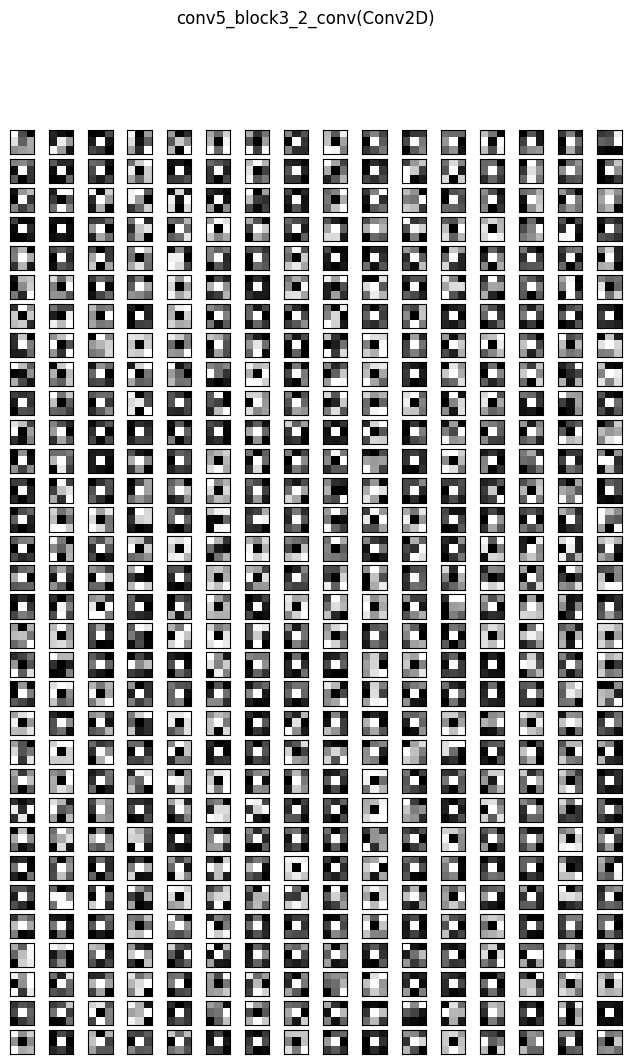

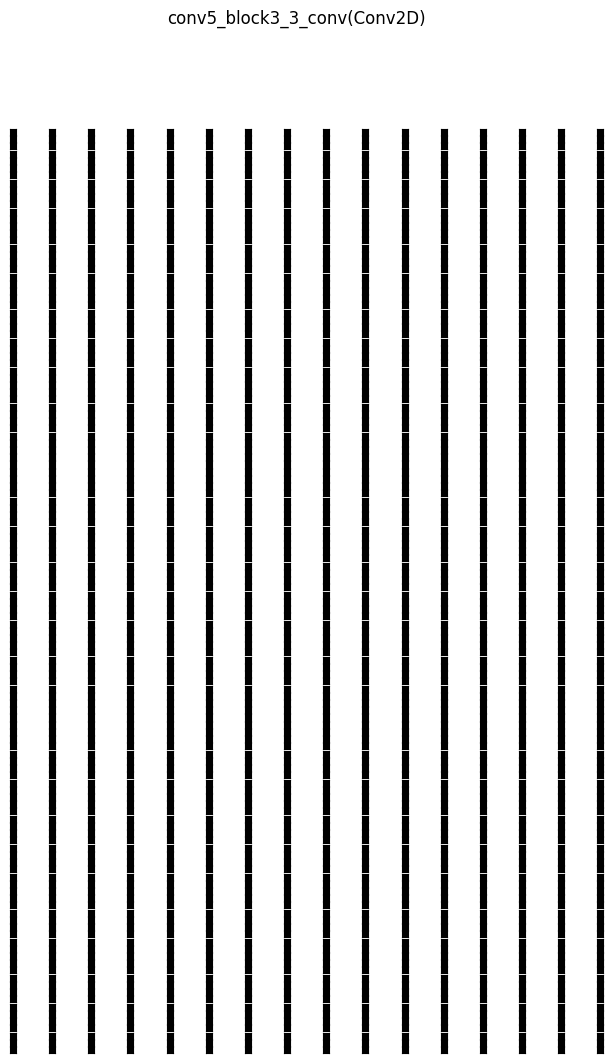

In [68]:
layer_names = get_layer_names(141, 172)
filters = get_filters(141, 172, layer_names)
plot_filters(layer_names, filters)

# Visualizing heatmaps of class activation in an image.

In [77]:
preds = model.predict(img_tensor)
print('Predicted:'+str(np.argmax(preds[0])))

ValueError: ignored

In [76]:
from keras import backend as K
# This is the "african elephant" entry in the prediction vector
output = model.output[:, 3]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model.get_layer('conv5_block3_3_conv')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(output, last_conv_layer.output)[0]

# This is a vector of shape (512,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `block5_conv3`,
# given a sample image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([img_ter])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the elephant class
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

RecursionError: ignored

In [ ]:
model.save("model.keras")

## PS 1.B - 20 points

In [this notebook](https://pantelis.github.io/artificial-intelligence/aiml-common/lectures/transfer-learning/transfer_learning_tutorial.html) we showcase _transfer learning_ using a pre-trained CNN model.

Perform the fine-tunning and feature extraction methods of transfer learning using the same model as in PS-1A, for the class `ship`.

Repeat the visualization of PS-1.A before and after  transfer learning and write a conclusive summary as to the relative value of the two methods.

In [ ]:
# Insert your code here